=== CONSERVATIVE REACTIVE ACO IRRIGATION OPTIMIZATION ===
This system is designed to:
- Match baseline irrigation amounts (no over-irrigation)
- Only irrigate when truly necessary
- Optimize timing to prefer cheaper night hours
- Use conservative heuristics
- Prevent unnecessary irrigation through conservative heuristics

Running Conservative Reactive ACO optimization...
Starting Conservative Reactive ACO Simulation:
- Only irrigates when truly necessary
- Optimizes timing for cost savings
- Conservative approach to prevent over-irrigation


Conservative ACO: 100%|█| 8760/8760 [00:00<00:00, 17634.48it/s, Hour=8700, Moisture=0.30, Violations=0, Night_Irrig=1, 



=== CONSERVATIVE REACTIVE ACO COMPLETE ===
Total cost: €35.95
Total consumption: 89.32 kWh
Total violations: 0
Total irrigation events: 55
Night irrigation events: 1 (1.8%)
Day irrigation events: 54
Unnecessary irrigation prevented: 8705 times

Running baseline simulation...

=== CONSERVATIVE REACTIVE ACO RESULTS SUMMARY ===
IRRIGATION AMOUNTS:
Baseline total irrigation: 307.6mm
Conservative ACO total irrigation: 297.7mm
Irrigation difference: -9.8mm (-3.2%)

ENERGY CONSUMPTION:
Baseline consumption: 92.27 kWh
Conservative ACO consumption: 89.32 kWh
Consumption difference: -2.95 kWh (-3.2%)

COST ANALYSIS:
Baseline total cost: €37.06
Conservative ACO total cost: €35.95
Cost savings: €1.11 (2.99%)

TIMING OPTIMIZATION:
Total irrigation events: 55
Night irrigation events: 1 (1.8%)
Day irrigation events: 54 (98.2%)
Unnecessary irrigation prevented: 8705 times

CONSTRAINT VIOLATIONS:
Conservative ACO violations: 0


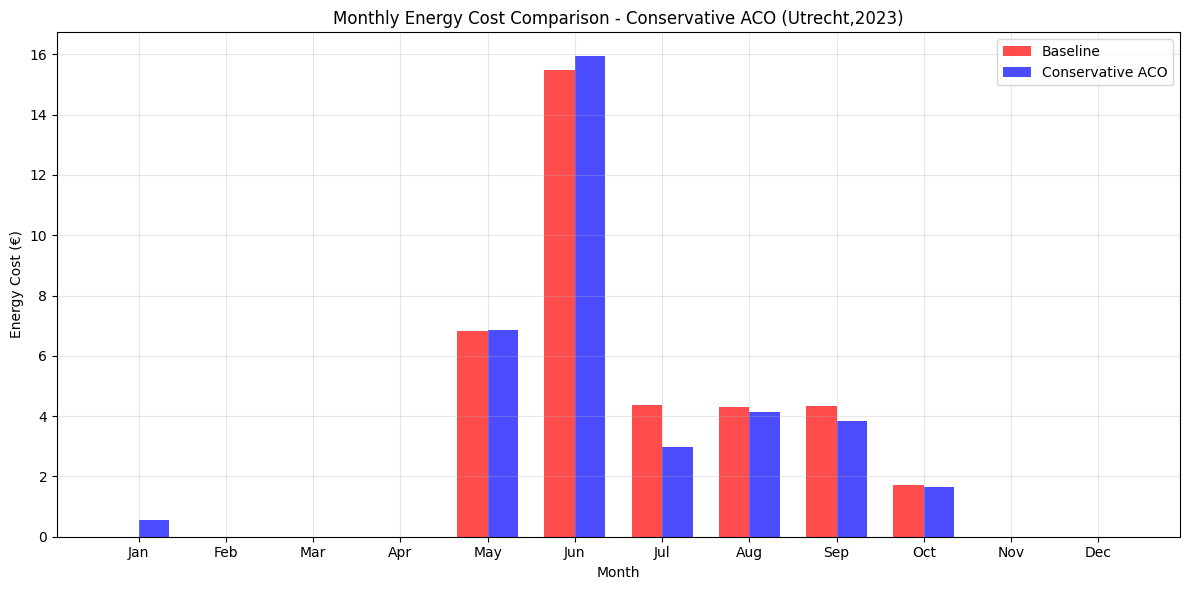

Creating comprehensive comparison for Conservative ACO...


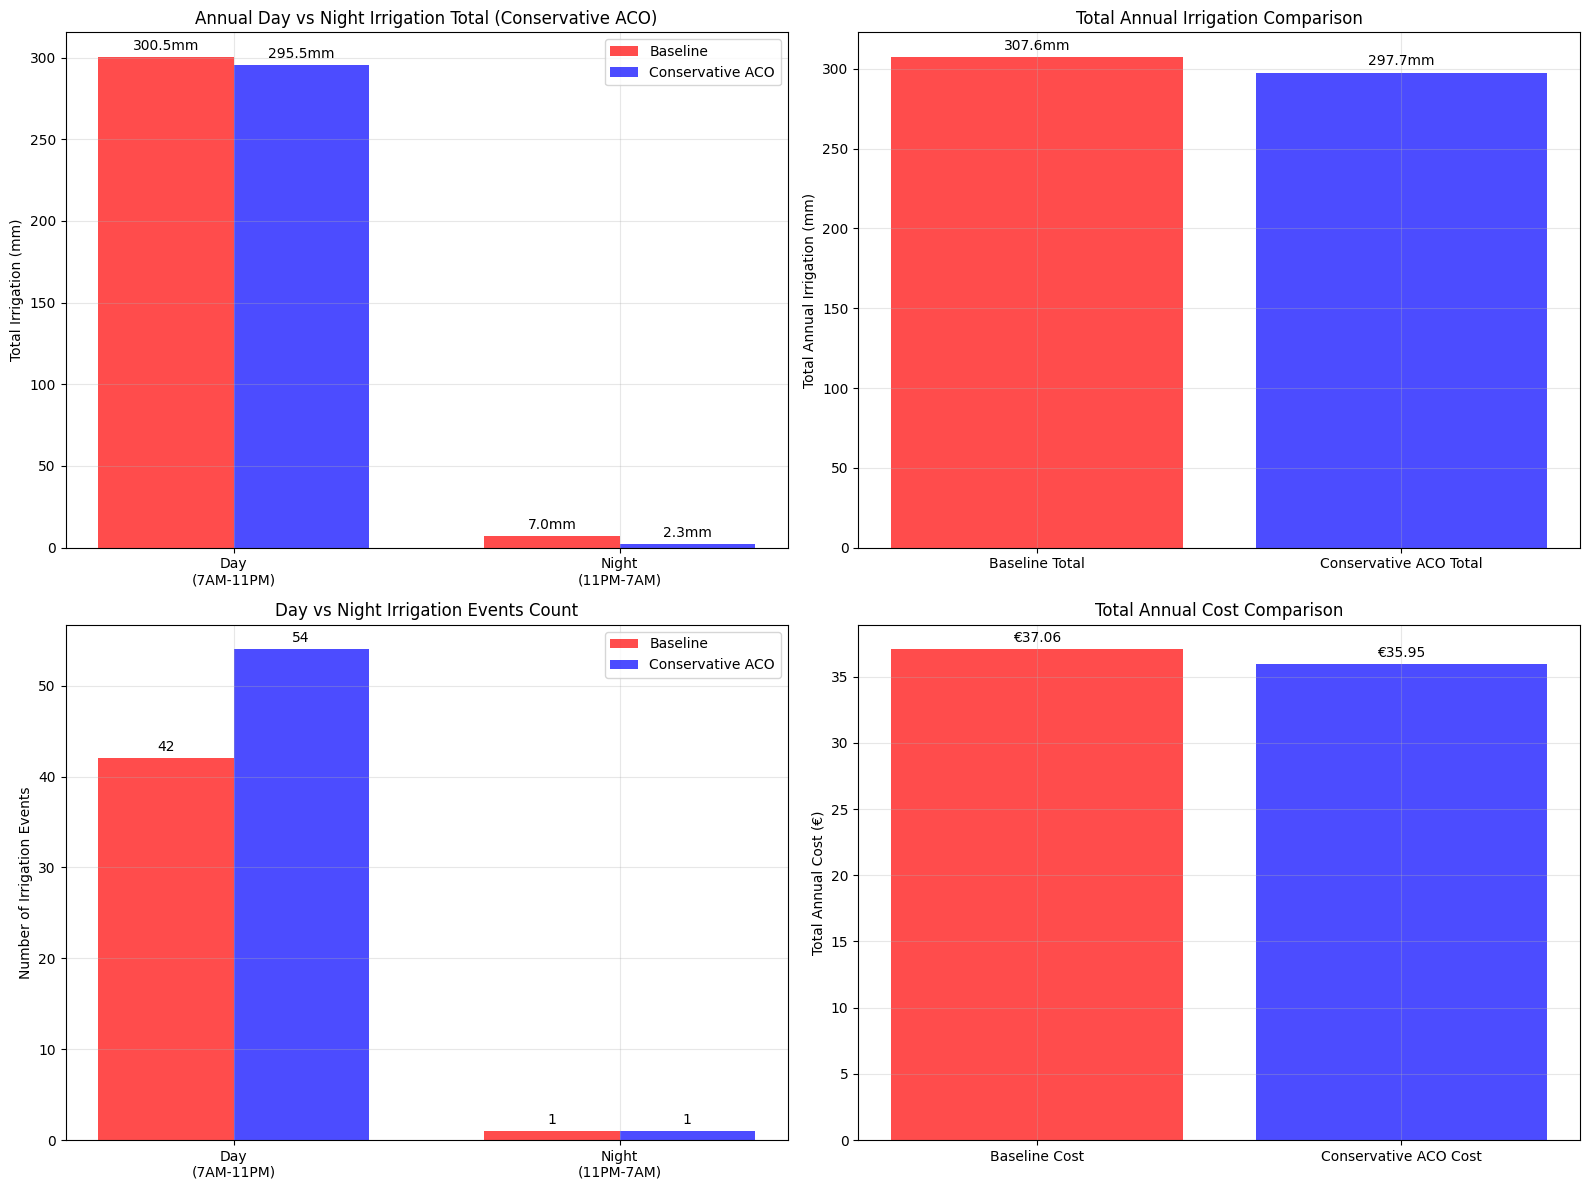


=== CONSERVATIVE ACO COMPARISON SUMMARY ===
IRRIGATION AMOUNTS:
Baseline total: 307.6mm
Conservative ACO total: 297.7mm
Difference: -9.8mm (-3.2%)

COST COMPARISON:
Baseline cost: €37.06
Conservative ACO cost: €35.95
Savings: €1.11 (3.0%)

TIMING OPTIMIZATION:
Conservative ACO - Day: 295.5mm in 54 events
Conservative ACO - Night: 2.3mm in 1 events
Night irrigation preference:
Conservative ACO: 0.8% of total irrigation
Baseline: 2.3% of total irrigation
Conservative ACO visualizations saved successfully!


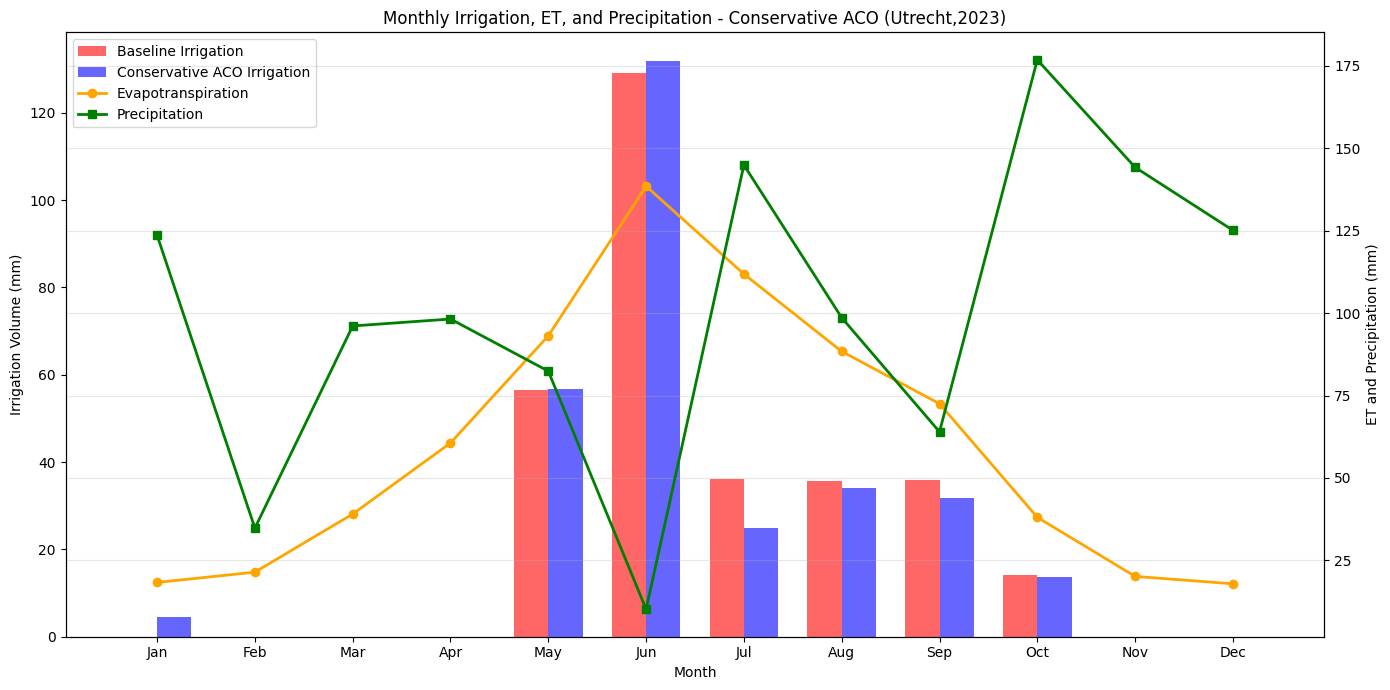


=== CONSERVATIVE ACO ASSESSMENT ===
Irrigation amount closely matches baseline (-3.2% difference)
Cost savings achieved: €1.11
Limited night irrigation: 1.8%


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator, WeekdayLocator
import datetime
import random
import copy
import pandas as pd
from tqdm import tqdm
import os

# Set random seed for reproducibility
np.random.seed(15)
random.seed(15)

class IrrigationSystem:
    def __init__(self, data_file='data.csv', soil_depth=100, 
                 min_moisture=0.18, max_moisture=0.25, saturation_point=0.3,
                 energy_per_unit=0.3, time_steps=8760):
        """
        Initialize the irrigation system for a golf course
        
        Parameters:
        - data_file: CSV file with weather data including ET and precipitation
        - soil_depth: Soil depth in mm
        - min_moisture: Minimum acceptable soil moisture (volumetric fraction)
        - max_moisture: Maximum optimal soil moisture (volumetric fraction)
        - saturation_point: Point at which water drains off (volumetric fraction)
        - energy_per_unit: Energy required per unit of irrigation (kWh/mm)
        - time_steps: Number of time steps (8760 hours for a year)
        """
        # System parameters
        self.num_zones = 1  # Single zone for golf course
        self.min_moisture = min_moisture
        self.max_moisture = max_moisture
        self.saturation_point = saturation_point
        self.soil_depth = soil_depth
        self.energy_per_unit = energy_per_unit
        self.time_steps = time_steps
        self.violation_buffer = 0.05
        
        # Load weather data from CSV
        self.load_weather_data(data_file)
        
        # Energy price model (€/kWh)
        # Create a yearly energy price array
        # Base pattern: 11PM-7AM: €0.34835, 7AM-11PM: €0.40292
        day_prices = np.array([0.34835] * 7 + [0.40292] * 16 + [0.34835] * 1)  
        self.energy_prices = np.tile(day_prices, 365)  # Repeat for 365 days
        
        # Initialize moisture level
        self.reset_moisture_level()
    
    def load_weather_data(self, data_file):
        """Load and process weather data from CSV file"""
        
        # Load data
        if not os.path.exists(data_file):
            raise FileNotFoundError(f"Weather data file '{data_file}' not found.")
        data = pd.read_csv(data_file)
        
        # Extract ET and precipitation data
        self.et_data = data['et0_fao_evapotranspiration (mm)'].values
        self.rain_data = data['rain (mm)'].values
        
        # Verify we have the correct number of hours
        if len(self.et_data) != self.time_steps:
            print(f"Warning: Expected {self.time_steps} hourly records but found {len(self.et_data)}")
            # Adjust time_steps to match data
            self.time_steps = min(self.time_steps, len(self.et_data))
                
        
        
    def reset_moisture_level(self):
        """Reset moisture level to random value within acceptable range"""
        # Convert to mm for internal calculations
        min_moisture_mm = self.min_moisture * self.soil_depth
        max_moisture_mm = self.max_moisture * self.soil_depth
        
        # Initialize random moisture level in mm
        moisture_mm = np.random.uniform(min_moisture_mm, max_moisture_mm)
        self.moisture_level = np.array([moisture_mm])
        
        return copy.deepcopy(self.moisture_level)
    
    def mm_to_fraction(self, moisture_mm):
        """Convert moisture in mm to volumetric fraction"""
        return moisture_mm / self.soil_depth
    
    def fraction_to_mm(self, moisture_fraction):
        """Convert volumetric fraction to moisture in mm"""
        return moisture_fraction * self.soil_depth
    
    def simulate_baseline(self, initial_moisture_mm, days=365):
        """
        Simulate baseline irrigation strategy: irrigate immediately when threshold is reached
        Returns energy cost, energy consumption and moisture trajectories
        
        Parameters:
        - initial_moisture_mm: Initial moisture level in mm
        - days: Number of days to simulate (default: 365)
        """
        hours = days * 24
        
        # Initialize tracking variables
        moisture_trajectory = np.zeros(hours)
        fraction_trajectory = np.zeros(hours)  # For visualization in volumetric fraction
        energy_cost_trajectory = np.zeros(hours)
        energy_consumption_trajectory = np.zeros(hours)  # NEW: Track energy consumption
        irrigation_actions = np.zeros(hours)
        
        # Set initial moisture
        current_moisture_mm = copy.deepcopy(initial_moisture_mm)[0]
        
        # Min and max moisture levels in mm
        min_moisture_mm = self.min_moisture * self.soil_depth
        max_moisture_mm = self.max_moisture * self.soil_depth
        saturation_mm = self.saturation_point * self.soil_depth
        
        # Simulate for the specified number of hours
        for hour in range(min(hours, self.time_steps)):
            # Record current moisture (both in mm and as fraction)
            moisture_trajectory[hour] = current_moisture_mm
            fraction_trajectory[hour] = self.mm_to_fraction(current_moisture_mm)
            
            # Apply natural water loss (ET from weather data)
            current_moisture_mm -= self.et_data[hour]
            
            # Add precipitation
            current_moisture_mm += self.rain_data[hour]
            
            # Cap at saturation point (excess water drains off)
            current_moisture_mm = min(current_moisture_mm, saturation_mm)
            
            # Enforce lower bound to prevent extreme dryness
            current_moisture_mm = max(current_moisture_mm, 0)
            
            # Check for irrigation needs (when moisture falls below minimum)
            irrigation_needed = 0
            if current_moisture_mm < min_moisture_mm:
                irrigation_needed = max_moisture_mm - current_moisture_mm
                # Apply irrigation
                current_moisture_mm += irrigation_needed
            
            # Record irrigation actions
            irrigation_actions[hour] = irrigation_needed
            
            # Calculate energy used and cost
            energy_used = irrigation_needed * self.energy_per_unit
            current_price = self.energy_prices[hour]
            energy_cost = energy_used * current_price
            
            # Record energy consumption and cost
            energy_consumption_trajectory[hour] = energy_used  # NEW
            energy_cost_trajectory[hour] = energy_cost
        
        # Calculate weekly and monthly costs and consumption for visualization
        weekly_costs = [np.sum(energy_cost_trajectory[w*168:(w+1)*168]) for w in range(52)]
        weekly_consumption = [np.sum(energy_consumption_trajectory[w*168:(w+1)*168]) for w in range(52)]  # NEW
        
        monthly_costs = []
        monthly_consumption = []  # NEW
        days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]  # Standard year
        
        # Adjust for leap year if necessary
        if days == 366:
            days_in_month[1] = 29
        
        hour_index = 0
        for month in range(12):
            month_hours = days_in_month[month] * 24
            monthly_costs.append(np.sum(energy_cost_trajectory[hour_index:hour_index+month_hours]))
            monthly_consumption.append(np.sum(energy_consumption_trajectory[hour_index:hour_index+month_hours]))  # NEW
            hour_index += month_hours
        
        # Return results
        return {
            'total_cost': np.sum(energy_cost_trajectory),
            'total_consumption': np.sum(energy_consumption_trajectory),  # NEW
            'weekly_costs': weekly_costs,
            'weekly_consumption': weekly_consumption,  # NEW
            'monthly_costs': monthly_costs,
            'monthly_consumption': monthly_consumption,  # NEW
            'moisture_trajectory': moisture_trajectory,
            'fraction_trajectory': fraction_trajectory,
            'energy_cost_trajectory': energy_cost_trajectory,
            'energy_consumption_trajectory': energy_consumption_trajectory,  # NEW
            'irrigation_actions': irrigation_actions
        }


class ReactiveACO:
    """
    Conservative Reactive ACO - only irrigates when necessary, but optimizes timing
    """
    def __init__(self, irrigation_system, num_ants=10, num_iterations=15, 
                 alpha=1.0, beta=2.0, evaporation_rate=0.3, q0=0.8):
        """
        Initialize Conservative Reactive ACO algorithm
        """
        self.irrigation_system = irrigation_system
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.q0 = q0
        
        # SMALLER action space to prevent over-irrigation
        max_irrigation = 0.25 * self.irrigation_system.soil_depth  # Reduced from 0.25
        self.possible_actions = np.linspace(0, max_irrigation, 12)  # Reduced from 15
        
        # Initialize pheromone memory
        self.moisture_states = 8   # Reduced from 10
        self.time_states = 24      # 24 hours of day
        
        # Pheromones: [moisture_state, time_state, action]
        self.pheromones = np.ones((
            self.moisture_states, 
            self.time_states, 
            len(self.possible_actions)
        ))
        
    def get_moisture_state(self, moisture_mm):
        """Convert moisture level to discrete state"""
        min_moisture = self.irrigation_system.min_moisture * self.irrigation_system.soil_depth
        max_moisture = self.irrigation_system.saturation_point * self.irrigation_system.soil_depth
        
        # Normalize moisture to 0-1 range
        normalized = (moisture_mm - min_moisture) / (max_moisture - min_moisture)
        normalized = max(0, min(1, normalized))
        
        # Convert to discrete state
        state = int(normalized * (self.moisture_states - 1))
        return min(state, self.moisture_states - 1)
    
    def calculate_current_heuristic(self, current_moisture_mm, current_hour):
        """
        CONSERVATIVE heuristic - only irrigate when truly necessary
        """
        heuristic = np.zeros(len(self.possible_actions))  # Start with zeros!
        
        # Basic parameters
        min_moisture_mm = self.irrigation_system.min_moisture * self.irrigation_system.soil_depth
        max_moisture_mm = self.irrigation_system.max_moisture * self.irrigation_system.soil_depth
        saturation_mm = self.irrigation_system.saturation_point * self.irrigation_system.soil_depth
        
        # Current conditions
        current_price = self.irrigation_system.energy_prices[current_hour]
        is_night = current_price < 0.39
        current_rain = self.irrigation_system.rain_data[current_hour] if current_hour < len(self.irrigation_system.rain_data) else 0
        
        # CRITICAL: Only consider irrigation if it's actually needed
        if current_moisture_mm >= min_moisture_mm:
            # No irrigation needed - return all zeros
            return heuristic
        
        # Calculate how much irrigation is actually required
        required_irrigation = max_moisture_mm - current_moisture_mm
        urgency = 1.0
        
        # Calculate heuristic only for reasonable actions
        for a_idx, action in enumerate(self.possible_actions):
            if action == 0:
                # No irrigation action
                if current_moisture_mm >= min_moisture_mm:
                    heuristic[a_idx] = 1.0  # Good to do nothing
                else:
                    heuristic[a_idx] = 0.1  # Bad to do nothing when irrigation needed
                continue
            
            # Check if action makes sense
            final_moisture = current_moisture_mm + action
            
            # Skip actions that cause over-saturation
            if final_moisture > saturation_mm:
                heuristic[a_idx] = 0.01
                continue
            
            # Skip actions during heavy rain
            if current_rain > 2.0:
                heuristic[a_idx] = 0.01
                continue
            
            # Calculate base score based on how well action meets need
            if action >= required_irrigation * 0.8:  # Action covers most of the need
                base_score = 1.0
            elif action >= required_irrigation * 0.5:  # Action covers some of the need
                base_score = 0.7
            else:  # Action is too small
                base_score = 0.3
            
            # Apply urgency
            base_score *= urgency
            
            # Apply timing preferences ONLY if irrigation is needed
            if is_night:
                # Night time bonus - but only if irrigation is actually needed
                base_score *= 1.8
            else:
                # Day time penalty
                base_score *= 0.6
            
            heuristic[a_idx] = max(0.01, base_score)
        
        return heuristic
    
    def make_irrigation_decision(self, current_moisture_mm, current_hour):
        """
        Make conservative irrigation decision - only when necessary
        """
        # Get current state
        moisture_state = self.get_moisture_state(current_moisture_mm)
        time_state = current_hour % 24
        
        # Calculate conservative heuristic
        heuristic = self.calculate_current_heuristic(current_moisture_mm, current_hour)
        
        # If all heuristic values are very low, don't irrigate
        if np.max(heuristic) < 0.1:
            return 0.0, {
                'best_quality': 0,
                'avg_quality': 0,
                'moisture_state': moisture_state,
                'time_state': time_state,
                'current_price': self.irrigation_system.energy_prices[current_hour],
                'is_night': self.irrigation_system.energy_prices[current_hour] < 0.39,
                'irrigation_needed': False
            }
        
        # Get pheromone values for current state
        current_pheromones = self.pheromones[moisture_state, time_state, :]
        
        # Run mini-ACO optimization
        best_action = 0.0
        best_quality = float('inf')
        
        # Track all ant decisions for learning
        ant_actions = []
        ant_qualities = []
        
        for iteration in range(self.num_iterations):
            for ant in range(self.num_ants):
                # Ant decision making
                q = np.random.random()
                
                if q < self.q0:  # Exploitation
                    action_probs = (current_pheromones ** self.alpha) * (heuristic ** self.beta)
                    action_idx = np.argmax(action_probs)
                else:  # Exploration
                    action_probs = (current_pheromones ** self.alpha) * (heuristic ** self.beta)
                    action_probs = action_probs / (np.sum(action_probs) + 1e-10)
                    action_idx = np.random.choice(len(self.possible_actions), p=action_probs)
                
                action = self.possible_actions[action_idx]
                
                # Evaluate action
                quality = self.evaluate_single_action(action, current_moisture_mm, current_hour)
                
                ant_actions.append((action, action_idx))
                ant_qualities.append(quality)
                
                # Track best
                if quality < best_quality:
                    best_action = action
                    best_quality = quality
        
        # Update pheromones
        self.update_pheromones_for_decision(moisture_state, time_state, ant_actions, ant_qualities)
        
        decision_stats = {
            'best_quality': best_quality,
            'avg_quality': np.mean(ant_qualities),
            'moisture_state': moisture_state,
            'time_state': time_state,
            'current_price': self.irrigation_system.energy_prices[current_hour],
            'is_night': self.irrigation_system.energy_prices[current_hour] < 0.39,
            'irrigation_needed': True
        }
        
        return best_action, decision_stats
    
    def evaluate_single_action(self, action, current_moisture_mm, current_hour):
        """
        Conservative evaluation with heavy penalties for unnecessary irrigation
        """
        # Project moisture after action and weather
        projected_moisture = current_moisture_mm + action
        
        # Apply current hour's ET and rain
        if current_hour < len(self.irrigation_system.et_data):
            projected_moisture -= self.irrigation_system.et_data[current_hour]
            projected_moisture += self.irrigation_system.rain_data[current_hour]
        
        # Cap at saturation
        saturation_mm = self.irrigation_system.saturation_point * self.irrigation_system.soil_depth
        projected_moisture = min(projected_moisture, saturation_mm)
        projected_moisture = max(0, projected_moisture)
        
        # Calculate energy cost
        energy_cost = action * self.irrigation_system.energy_per_unit * self.irrigation_system.energy_prices[current_hour]
        
        # Conservative penalties
        min_moisture_mm = self.irrigation_system.min_moisture * self.irrigation_system.soil_depth
        max_moisture_mm = self.irrigation_system.max_moisture * self.irrigation_system.soil_depth
        
        penalty = 0
        
        # Under-irrigation penalty
        if projected_moisture < min_moisture_mm:
            penalty += 10.0
        
        # Over-irrigation penalty (very high to prevent waste)
        if projected_moisture > max_moisture_mm + 0.02 * self.irrigation_system.soil_depth:
            penalty += 50.0
        
        # Heavy penalty for unnecessary irrigation
        if action > 0 and current_moisture_mm > min_moisture_mm:
            penalty += 100.0  # Very high penalty for unnecessary irrigation
        
        # Rain waste penalty
        current_rain = self.irrigation_system.rain_data[current_hour] if current_hour < len(self.irrigation_system.rain_data) else 0
        if current_rain > 1.0 and action > 0:
            penalty += current_rain * action * 10.0  # High rain penalty
        
        return energy_cost + penalty
    
    def update_pheromones_for_decision(self, moisture_state, time_state, ant_actions, ant_qualities):
        """
        Update pheromones based on ant decisions
        """
        # Evaporation
        self.pheromones[moisture_state, time_state, :] *= (1 - self.evaporation_rate)
        
        # Find best quality for normalization
        if len(ant_qualities) > 0:
            best_quality = min(ant_qualities)
            
            # Deposit pheromones
            for (action, action_idx), quality in zip(ant_actions, ant_qualities):
                if quality > 0:
                    relative_quality = best_quality / quality
                    pheromone_deposit = relative_quality
                    
                    # Add pheromone
                    self.pheromones[moisture_state, time_state, action_idx] += pheromone_deposit


def run_reactive_aco_simulation(irrigation_system, verbose=True):
    """
    Run Conservative Reactive ACO simulation for the entire year
    """
    
    if verbose:
        print("Starting Conservative Reactive ACO Simulation:")
        print("- Only irrigates when truly necessary")
        print("- Optimizes timing for cost savings")
        print("- Conservative approach to prevent over-irrigation")
    
    # Initialize Conservative Reactive ACO
    aco = ReactiveACO(irrigation_system)
    
    # Initialize tracking variables
    full_year_schedule = np.zeros(irrigation_system.time_steps)
    full_year_moisture = np.zeros(irrigation_system.time_steps)
    full_year_fraction = np.zeros(irrigation_system.time_steps)
    full_year_cost = np.zeros(irrigation_system.time_steps)
    full_year_consumption = np.zeros(irrigation_system.time_steps)
    full_year_violations = np.zeros((irrigation_system.time_steps, 2))
    
    # Initialize moisture level
    current_moisture_mm = irrigation_system.reset_moisture_level()[0]
    
    # Track decision statistics
    decision_stats_list = []
    total_violations = 0
    night_irrigation_count = 0
    day_irrigation_count = 0
    total_night_hours = 0
    total_day_hours = 0
    unnecessary_irrigation_prevented = 0
    
    # Create progress bar
    pbar = tqdm(total=irrigation_system.time_steps, desc="Conservative ACO") if verbose else None
    
    # Hour-by-hour reactive decisions
    for hour in range(irrigation_system.time_steps):
        # Record current moisture state
        full_year_moisture[hour] = current_moisture_mm
        full_year_fraction[hour] = irrigation_system.mm_to_fraction(current_moisture_mm)
        
        # Make irrigation decision
        irrigation_action, decision_stats = aco.make_irrigation_decision(current_moisture_mm, hour)
        
        # Track timing statistics
        is_night = decision_stats['is_night']
        if is_night:
            total_night_hours += 1
            if irrigation_action > 0.1:
                night_irrigation_count += 1
        else:
            total_day_hours += 1
            if irrigation_action > 0.1:
                day_irrigation_count += 1
        
        # Track unnecessary irrigation prevention
        if not decision_stats.get('irrigation_needed', True) and irrigation_action < 0.1:
            unnecessary_irrigation_prevented += 1
        
        # Record decision
        full_year_schedule[hour] = irrigation_action
        decision_stats_list.append(decision_stats)
        
        # Apply irrigation
        current_moisture_mm += irrigation_action
        
        # Cap at saturation
        saturation_mm = irrigation_system.saturation_point * irrigation_system.soil_depth
        if current_moisture_mm > saturation_mm:
            current_moisture_mm = saturation_mm
        
        # Calculate energy and cost
        energy_used = irrigation_action * irrigation_system.energy_per_unit
        energy_cost = energy_used * irrigation_system.energy_prices[hour]
        
        full_year_consumption[hour] = energy_used
        full_year_cost[hour] = energy_cost
        
        # Apply ET and rain
        current_moisture_mm -= irrigation_system.et_data[hour]
        current_moisture_mm += irrigation_system.rain_data[hour]
        
        # Cap at saturation again
        current_moisture_mm = min(current_moisture_mm, saturation_mm)
        
        # Check for violations
        min_moisture_mm = irrigation_system.min_moisture * irrigation_system.soil_depth
        max_moisture_mm = irrigation_system.max_moisture * irrigation_system.soil_depth
        
        if current_moisture_mm > (max_moisture_mm + irrigation_system.violation_buffer * irrigation_system.soil_depth):
            full_year_violations[hour, 1] = 1
            total_violations += 1
        if current_moisture_mm < (min_moisture_mm - irrigation_system.violation_buffer * irrigation_system.soil_depth):
            full_year_violations[hour, 0] = 1
            total_violations += 1
        
        # Enforce bounds
        current_moisture_mm = max(current_moisture_mm, 0)
        
        # Update progress bar
        if pbar and hour % 100 == 0:
            pbar.set_postfix({
                'Hour': hour,
                'Moisture': f'{irrigation_system.mm_to_fraction(current_moisture_mm):.2f}',
                'Violations': total_violations,
                'Night_Irrig': f'{night_irrigation_count}',
                'Day_Irrig': f'{day_irrigation_count}'
            })
        
        if pbar:
            pbar.update(1)
    
    if pbar:
        pbar.close()
    
    # Calculate aggregations
    weekly_costs = [np.sum(full_year_cost[w*168:(w+1)*168]) for w in range(52)]
    weekly_consumption = [np.sum(full_year_consumption[w*168:(w+1)*168]) for w in range(52)]
    
    monthly_costs = []
    monthly_consumption = []
    days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    
    hour_index = 0
    for month in range(12):
        month_hours = days_in_month[month] * 24
        monthly_costs.append(np.sum(full_year_cost[hour_index:hour_index+month_hours]))
        monthly_consumption.append(np.sum(full_year_consumption[hour_index:hour_index+month_hours]))
        hour_index += month_hours
    
    # Calculate efficiency metrics
    total_irrigation_events = night_irrigation_count + day_irrigation_count
    night_percentage = (night_irrigation_count / total_irrigation_events * 100) if total_irrigation_events > 0 else 0
    
    # Print summary with conservation stats
    if verbose:
        print(f"\n=== CONSERVATIVE REACTIVE ACO COMPLETE ===")
        print(f"Total cost: €{np.sum(full_year_cost):.2f}")
        print(f"Total consumption: {np.sum(full_year_consumption):.2f} kWh")
        print(f"Total violations: {total_violations}")
        print(f"Total irrigation events: {total_irrigation_events}")
        print(f"Night irrigation events: {night_irrigation_count} ({night_percentage:.1f}%)")
        print(f"Day irrigation events: {day_irrigation_count}")
        print(f"Unnecessary irrigation prevented: {unnecessary_irrigation_prevented} times")
    
    return {
        'total_cost': np.sum(full_year_cost),
        'pure_cost': np.sum(full_year_cost),
        'total_consumption': np.sum(full_year_consumption),
        'weekly_costs': weekly_costs,
        'weekly_consumption': weekly_consumption,
        'monthly_costs': monthly_costs,
        'monthly_consumption': monthly_consumption,
        'moisture_trajectory': full_year_moisture,
        'fraction_trajectory': full_year_fraction,
        'energy_cost_trajectory': full_year_cost,
        'energy_consumption_trajectory': full_year_consumption,
        'irrigation_actions': full_year_schedule,
        'min_violations': int(np.sum(full_year_violations[:, 0])),
        'max_violations': int(np.sum(full_year_violations[:, 1])),
        'hourly_violations': full_year_violations,
        'decision_stats': decision_stats_list,
        'night_irrigation_count': night_irrigation_count,
        'day_irrigation_count': day_irrigation_count,
        'total_irrigation_events': total_irrigation_events,
        'unnecessary_prevented': unnecessary_irrigation_prevented
    }


def add_day_night_irrigation_plot(irrigation_system, aco_result, baseline_result, days=365):
    """Day vs night irrigation comparison plot"""
    
    # Calculate day vs night irrigation
    total_day_aco = 0
    total_night_aco = 0
    total_day_baseline = 0
    total_night_baseline = 0
    
    # Count irrigation events
    day_events_aco = 0
    night_events_aco = 0
    day_events_baseline = 0
    night_events_baseline = 0
    
    for hour in range(min(days * 24, len(aco_result['irrigation_actions']))):
        hour_of_day = hour % 24
        is_expensive = irrigation_system.energy_prices[hour_of_day] >= 0.39
        
        aco_irrigation = aco_result['irrigation_actions'][hour]
        baseline_irrigation = baseline_result['irrigation_actions'][hour]
        
        if is_expensive:  # Day time
            total_day_aco += aco_irrigation
            total_day_baseline += baseline_irrigation
            if aco_irrigation > 0.1:
                day_events_aco += 1
            if baseline_irrigation > 0.1:
                day_events_baseline += 1
        else:  # Night time
            total_night_aco += aco_irrigation
            total_night_baseline += baseline_irrigation
            if aco_irrigation > 0.1:
                night_events_aco += 1
            if baseline_irrigation > 0.1:
                night_events_baseline += 1
    
    # Create visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Total irrigation amounts
    categories = ['Day\n(7AM-11PM)', 'Night\n(11PM-7AM)']
    aco_totals = [total_day_aco, total_night_aco]
    baseline_totals = [total_day_baseline, total_night_baseline]
    
    x = np.arange(len(categories))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, baseline_totals, width, label='Baseline', color='red', alpha=0.7)
    bars2 = ax1.bar(x + width/2, aco_totals, width, label='Conservative ACO', color='blue', alpha=0.7)
    
    ax1.set_ylabel('Total Irrigation (mm)')
    ax1.set_title('Annual Day vs Night Irrigation Total (Conservative ACO)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(categories)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax1.annotate(f'{height:.1f}mm',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')
    
    for bar in bars2:
        height = bar.get_height()
        ax1.annotate(f'{height:.1f}mm',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')
    
    # Plot 2: Total irrigation comparison
    total_aco = total_day_aco + total_night_aco
    total_baseline = total_day_baseline + total_night_baseline
    
    totals = ['Baseline Total', 'Conservative ACO Total']
    amounts = [total_baseline, total_aco]
    colors = ['red', 'blue']
    
    bars = ax2.bar(totals, amounts, color=colors, alpha=0.7)
    ax2.set_ylabel('Total Annual Irrigation (mm)')
    ax2.set_title('Total Annual Irrigation Comparison')
    ax2.grid(True, alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax2.annotate(f'{height:.1f}mm',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')
    
    # Plot 3: Irrigation events count
    aco_events = [day_events_aco, night_events_aco]
    baseline_events = [day_events_baseline, night_events_baseline]
    
    bars3 = ax3.bar(x - width/2, baseline_events, width, label='Baseline', color='red', alpha=0.7)
    bars4 = ax3.bar(x + width/2, aco_events, width, label='Conservative ACO', color='blue', alpha=0.7)
    
    ax3.set_ylabel('Number of Irrigation Events')
    ax3.set_title('Day vs Night Irrigation Events Count')
    ax3.set_xticks(x)
    ax3.set_xticklabels(categories)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Add event count labels
    for bar in bars3:
        height = bar.get_height()
        ax3.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')
    
    for bar in bars4:
        height = bar.get_height()
        ax3.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')
    
    # Plot 4: Cost comparison
    aco_cost = aco_result['total_cost']
    baseline_cost = baseline_result['total_cost']
    
    cost_categories = ['Baseline Cost', 'Conservative ACO Cost']
    costs = [baseline_cost, aco_cost]
    cost_colors = ['red', 'blue']
    
    bars5 = ax4.bar(cost_categories, costs, color=cost_colors, alpha=0.7)
    ax4.set_ylabel('Total Annual Cost (€)')
    ax4.set_title('Total Annual Cost Comparison')
    ax4.grid(True, alpha=0.3)
    
    for bar in bars5:
        height = bar.get_height()
        ax4.annotate(f'€{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('conservative_aco_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print comprehensive statistics
    print(f"\n=== CONSERVATIVE ACO COMPARISON SUMMARY ===")
    print(f"IRRIGATION AMOUNTS:")
    print(f"Baseline total: {total_baseline:.1f}mm")
    print(f"Conservative ACO total: {total_aco:.1f}mm")
    print(f"Difference: {total_aco - total_baseline:.1f}mm ({((total_aco - total_baseline)/total_baseline*100):.1f}%)")
    print(f"\nCOST COMPARISON:")
    print(f"Baseline cost: €{baseline_cost:.2f}")
    print(f"Conservative ACO cost: €{aco_cost:.2f}")
    print(f"Savings: €{baseline_cost - aco_cost:.2f} ({((baseline_cost - aco_cost)/baseline_cost*100):.1f}%)")
    print(f"\nTIMING OPTIMIZATION:")
    print(f"Conservative ACO - Day: {total_day_aco:.1f}mm in {day_events_aco} events")
    print(f"Conservative ACO - Night: {total_night_aco:.1f}mm in {night_events_aco} events")
    
    night_preference_aco = (total_night_aco / total_aco * 100) if total_aco > 0 else 0
    night_preference_baseline = (total_night_baseline / total_baseline * 100) if total_baseline > 0 else 0
    
    print(f"Night irrigation preference:")
    print(f"Conservative ACO: {night_preference_aco:.1f}% of total irrigation")
    print(f"Baseline: {night_preference_baseline:.1f}% of total irrigation")


def visualize_results(irrigation_system, aco_result, baseline_result, days=365):
    """Create visualizations comparing Conservative ACO with baseline"""
    
    # Figure 1: Monthly Energy Costs
    plt.figure(figsize=(12, 6))
    aco_monthly_costs = aco_result['monthly_costs']
    baseline_monthly_costs = baseline_result['monthly_costs']
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    x = np.arange(len(months))
    width = 0.35
    
    plt.bar(x - width/2, baseline_monthly_costs, width, label='Baseline', color='r', alpha=0.7)
    plt.bar(x + width/2, aco_monthly_costs, width, label='Conservative ACO', color='b', alpha=0.7)
    
    plt.xlabel('Month')
    plt.ylabel('Energy Cost (€)')
    plt.title('Monthly Energy Cost Comparison - Conservative ACO (Utrecht,2023)')
    plt.xticks(x, months)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('conservative_aco_monthly_energy_costs.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Figure 2: Comprehensive comparison
    print("Creating comprehensive comparison for Conservative ACO...")
    add_day_night_irrigation_plot(irrigation_system, aco_result, baseline_result, days)
    
    print("Conservative ACO visualizations saved successfully!")

    # Calculate total irrigation volume by month
    monthly_aco_irrigation = []
    monthly_baseline_irrigation = []
    monthly_et = []
    monthly_rain = []
    
    days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]  # Standard year
    hour_index = 0
    
    for month in range(12):
        month_hours = days_in_month[month] * 24
        
        monthly_aco_irrigation.append(np.sum(aco_result['irrigation_actions'][hour_index:hour_index+month_hours]))
        monthly_baseline_irrigation.append(np.sum(baseline_result['irrigation_actions'][hour_index:hour_index+month_hours]))
        monthly_et.append(np.sum(irrigation_system.et_data[hour_index:hour_index+month_hours]))
        monthly_rain.append(np.sum(irrigation_system.rain_data[hour_index:hour_index+month_hours]))
        
        hour_index += month_hours
    
    # Create positions for bars
    x = np.arange(len(months))
    width = 0.35
    
    # Create bar chart
    fig, ax1 = plt.subplots(figsize=(14, 7))
    
    # Irrigation data on left y-axis
    ax1.bar(x - width/2, monthly_baseline_irrigation, width, label='Baseline Irrigation', color='r', alpha=0.6)
    ax1.bar(x + width/2, monthly_aco_irrigation, width, label='Conservative ACO Irrigation', color='b', alpha=0.6)
    ax1.set_ylabel('Irrigation Volume (mm)')
    ax1.set_xlabel('Month')
    ax1.set_title('Monthly Irrigation, ET, and Precipitation - Conservative ACO (Utrecht,2023)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(months)
    
    # Create second y-axis for ET and rain
    ax2 = ax1.twinx()
    ax2.plot(x, monthly_et, 'orange', marker='o', linestyle='-', linewidth=2, label='Evapotranspiration')
    ax2.plot(x, monthly_rain, 'green', marker='s', linestyle='-', linewidth=2, label='Precipitation')
    ax2.set_ylabel('ET and Precipitation (mm)')
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('rolling_aco_annual_water_distribution.png')
    plt.show()


def reactive_aco_simulation(days=365):
    """
    Run Conservative Reactive ACO simulation with comparison to baseline
    """
    # Create irrigation system
    irrigation_system = IrrigationSystem()
    
    # Store initial moisture level for fair comparison
    initial_moisture_mm = irrigation_system.reset_moisture_level()
    
    # Run Conservative Reactive ACO optimization
    print("Running Conservative Reactive ACO optimization...")
    aco_result = run_reactive_aco_simulation(irrigation_system, verbose=True)
    
    # Run baseline for comparison
    print("\nRunning baseline simulation...")
    baseline_result = irrigation_system.simulate_baseline(initial_moisture_mm, days=days)
    
    # Calculate performance metrics
    total_aco_cost = aco_result['pure_cost']
    total_baseline_cost = baseline_result['total_cost']
    savings = total_baseline_cost - total_aco_cost
    savings_percentage = (savings / total_baseline_cost) * 100
    
    total_aco_consumption = aco_result['total_consumption']
    total_baseline_consumption = baseline_result['total_consumption']
    consumption_diff = total_aco_consumption - total_baseline_consumption
    consumption_diff_percentage = (consumption_diff / total_baseline_consumption) * 100
    
    total_aco_irrigation = np.sum(aco_result['irrigation_actions'])
    total_baseline_irrigation = np.sum(baseline_result['irrigation_actions'])
    irrigation_diff = total_aco_irrigation - total_baseline_irrigation
    irrigation_diff_percentage = (irrigation_diff / total_baseline_irrigation) * 100
    
    print(f"\n=== CONSERVATIVE REACTIVE ACO RESULTS SUMMARY ===")
    print(f"IRRIGATION AMOUNTS:")
    print(f"Baseline total irrigation: {total_baseline_irrigation:.1f}mm")
    print(f"Conservative ACO total irrigation: {total_aco_irrigation:.1f}mm")
    print(f"Irrigation difference: {irrigation_diff:.1f}mm ({irrigation_diff_percentage:.1f}%)")
    
    print(f"\nENERGY CONSUMPTION:")
    print(f"Baseline consumption: {total_baseline_consumption:.2f} kWh")
    print(f"Conservative ACO consumption: {total_aco_consumption:.2f} kWh")
    print(f"Consumption difference: {consumption_diff:.2f} kWh ({consumption_diff_percentage:.1f}%)")
    
    print(f"\nCOST ANALYSIS:")
    print(f"Baseline total cost: €{total_baseline_cost:.2f}")
    print(f"Conservative ACO total cost: €{total_aco_cost:.2f}")
    if savings > 0:
        print(f"Cost savings: €{savings:.2f} ({savings_percentage:.2f}%)")
    else:
        print(f"Cost increase: €{-savings:.2f} ({-savings_percentage:.2f}%)")
    
    # Timing analysis
    if 'total_irrigation_events' in aco_result:
        total_events = aco_result['total_irrigation_events']
        night_events = aco_result['night_irrigation_count']
        day_events = aco_result['day_irrigation_count']
        night_percentage = (night_events / total_events * 100) if total_events > 0 else 0
        
        print(f"\nTIMING OPTIMIZATION:")
        print(f"Total irrigation events: {total_events}")
        print(f"Night irrigation events: {night_events} ({night_percentage:.1f}%)")
        print(f"Day irrigation events: {day_events} ({100-night_percentage:.1f}%)")
        print(f"Unnecessary irrigation prevented: {aco_result.get('unnecessary_prevented', 0)} times")
    
    # Constraint violations
    print(f"\nCONSTRAINT VIOLATIONS:")
    print(f"Conservative ACO violations: {aco_result['min_violations'] + aco_result['max_violations']}")
    
    
    # Visualize results
    visualize_results(irrigation_system, aco_result, baseline_result, days)
    
    # Final assessment
    print(f"\n=== CONSERVATIVE ACO ASSESSMENT ===")
    if abs(irrigation_diff_percentage) < 5:
        print(f"Irrigation amount closely matches baseline ({irrigation_diff_percentage:.1f}% difference)")
    else:
        print(f"Irrigation amount differs from baseline by {irrigation_diff_percentage:.1f}%")
    
    if savings > 0:
        print(f"Cost savings achieved: €{savings:.2f}")
    else:
        print(f"Cost increased by: €{-savings:.2f}")
    
    if night_percentage > 30:
        print(f"Good night irrigation preference: {night_percentage:.1f}%")
    else:
        print(f"Limited night irrigation: {night_percentage:.1f}%")
    
    return aco_result, baseline_result


if __name__ == "__main__":
    # Run Conservative Reactive ACO simulation
    print("=== CONSERVATIVE REACTIVE ACO IRRIGATION OPTIMIZATION ===")
    print("This system is designed to:")
    print("- Match baseline irrigation amounts (no over-irrigation)")
    print("- Only irrigate when truly necessary")
    print("- Optimize timing to prefer cheaper night hours")
    print("- Use conservative heuristics")
    print("- Prevent unnecessary irrigation through conservative heuristics")
    print()
    
    aco_result, baseline_result = reactive_aco_simulation(days=365)

=== MAX-MIN ANT SYSTEM (MMAS) IRRIGATION OPTIMIZATION ===
This system is designed to:
- Match baseline irrigation amounts (no over-irrigation)
- Only irrigate when truly necessary
- Optimize timing to prefer cheaper night hours
- Use conservative heuristics
- Prevent unnecessary irrigation through conservative heuristics
- Use pheromone bounds (tau_min, tau_max) to prevent stagnation
- Only allow best ant to update pheromones
- Reinitialize pheromones when stagnation is detected

Running Max-Min Ant System (MMAS) optimization...
Starting Max-Min Ant System (MMAS) Simulation:
- Only irrigates when truly necessary
- Optimizes timing for cost savings
- Conservative approach to prevent over-irrigation
- Uses pheromone bounds and stagnation detection


MMAS:  38%|▍| 3300/8760 [00:00<00:00, 22567.53it/s, Hour=3300, Moisture=0.21, Violations=0, Night_Irrig=0, Day_Irrig=7]

    Stagnation detected, reinitializing pheromones...


MMAS:  47%|▍| 4100/8760 [00:00<00:00, 22567.53it/s, Hour=4100, Moisture=0.23, Violations=0, Night_Irrig=4, Day_Irrig=44

    Stagnation detected, reinitializing pheromones...
    Stagnation detected, reinitializing pheromones...
    Stagnation detected, reinitializing pheromones...
    Stagnation detected, reinitializing pheromones...
    Stagnation detected, reinitializing pheromones...
    Stagnation detected, reinitializing pheromones...
    Stagnation detected, reinitializing pheromones...


MMAS:  48%|▍| 4200/8760 [00:00<00:00, 22567.53it/s, Hour=4200, Moisture=0.19, Violations=0, Night_Irrig=4, Day_Irrig=48

    Stagnation detected, reinitializing pheromones...


MMAS:  65%|▋| 5700/8760 [00:00<00:00, 8669.65it/s, Hour=5700, Moisture=0.27, Violations=0, Night_Irrig=5, Day_Irrig=73]

    Stagnation detected, reinitializing pheromones...
    Stagnation detected, reinitializing pheromones...
    Stagnation detected, reinitializing pheromones...
    Stagnation detected, reinitializing pheromones...
    Stagnation detected, reinitializing pheromones...


MMAS:  68%|▋| 6000/8760 [00:00<00:00, 9252.75it/s, Hour=6000, Moisture=0.20, Violations=0, Night_Irrig=5, Day_Irrig=76]

    Stagnation detected, reinitializing pheromones...


MMAS: 100%|█| 8760/8760 [00:00<00:00, 11484.15it/s, Hour=8700, Moisture=0.30, Violations=0, Night_Irrig=5, Day_Irrig=84


    Stagnation detected, reinitializing pheromones...

=== MAX-MIN ANT SYSTEM (MMAS) COMPLETE ===
Total cost: €34.90
Total consumption: 87.27 kWh
Total violations: 0
Total irrigation events: 89
Night irrigation events: 5 (5.6%)
Day irrigation events: 84
Unnecessary irrigation prevented: 8671 times

Running baseline simulation...

=== MAX-MIN ANT SYSTEM (MMAS) RESULTS SUMMARY ===
IRRIGATION AMOUNTS:
Baseline total irrigation: 307.6mm
MMAS total irrigation: 290.9mm
Irrigation difference: -16.6mm (-5.4%)

ENERGY CONSUMPTION:
Baseline consumption: 92.27 kWh
MMAS consumption: 87.27 kWh
Consumption difference: -4.99 kWh (-5.4%)

COST ANALYSIS:
Baseline total cost: €37.06
MMAS total cost: €34.90
Cost savings: €2.16 (5.82%)

TIMING OPTIMIZATION:
Total irrigation events: 89
Night irrigation events: 5 (5.6%)
Day irrigation events: 84 (94.4%)
Unnecessary irrigation prevented: 8671 times

CONSTRAINT VIOLATIONS:
MMAS violations: 0


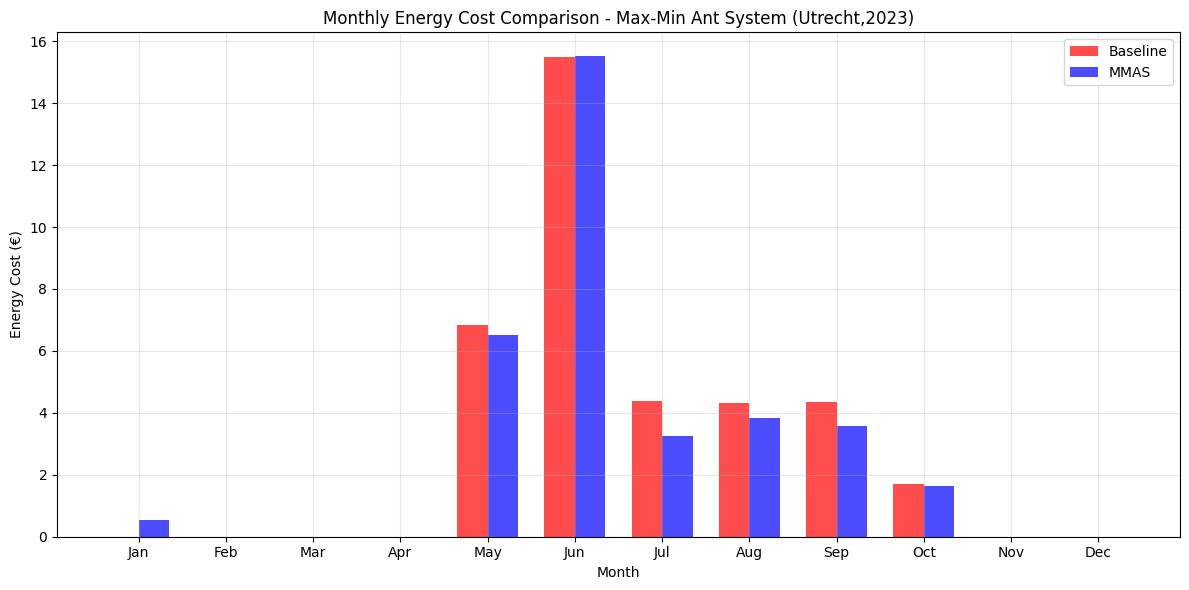

Creating comprehensive comparison for MMAS...


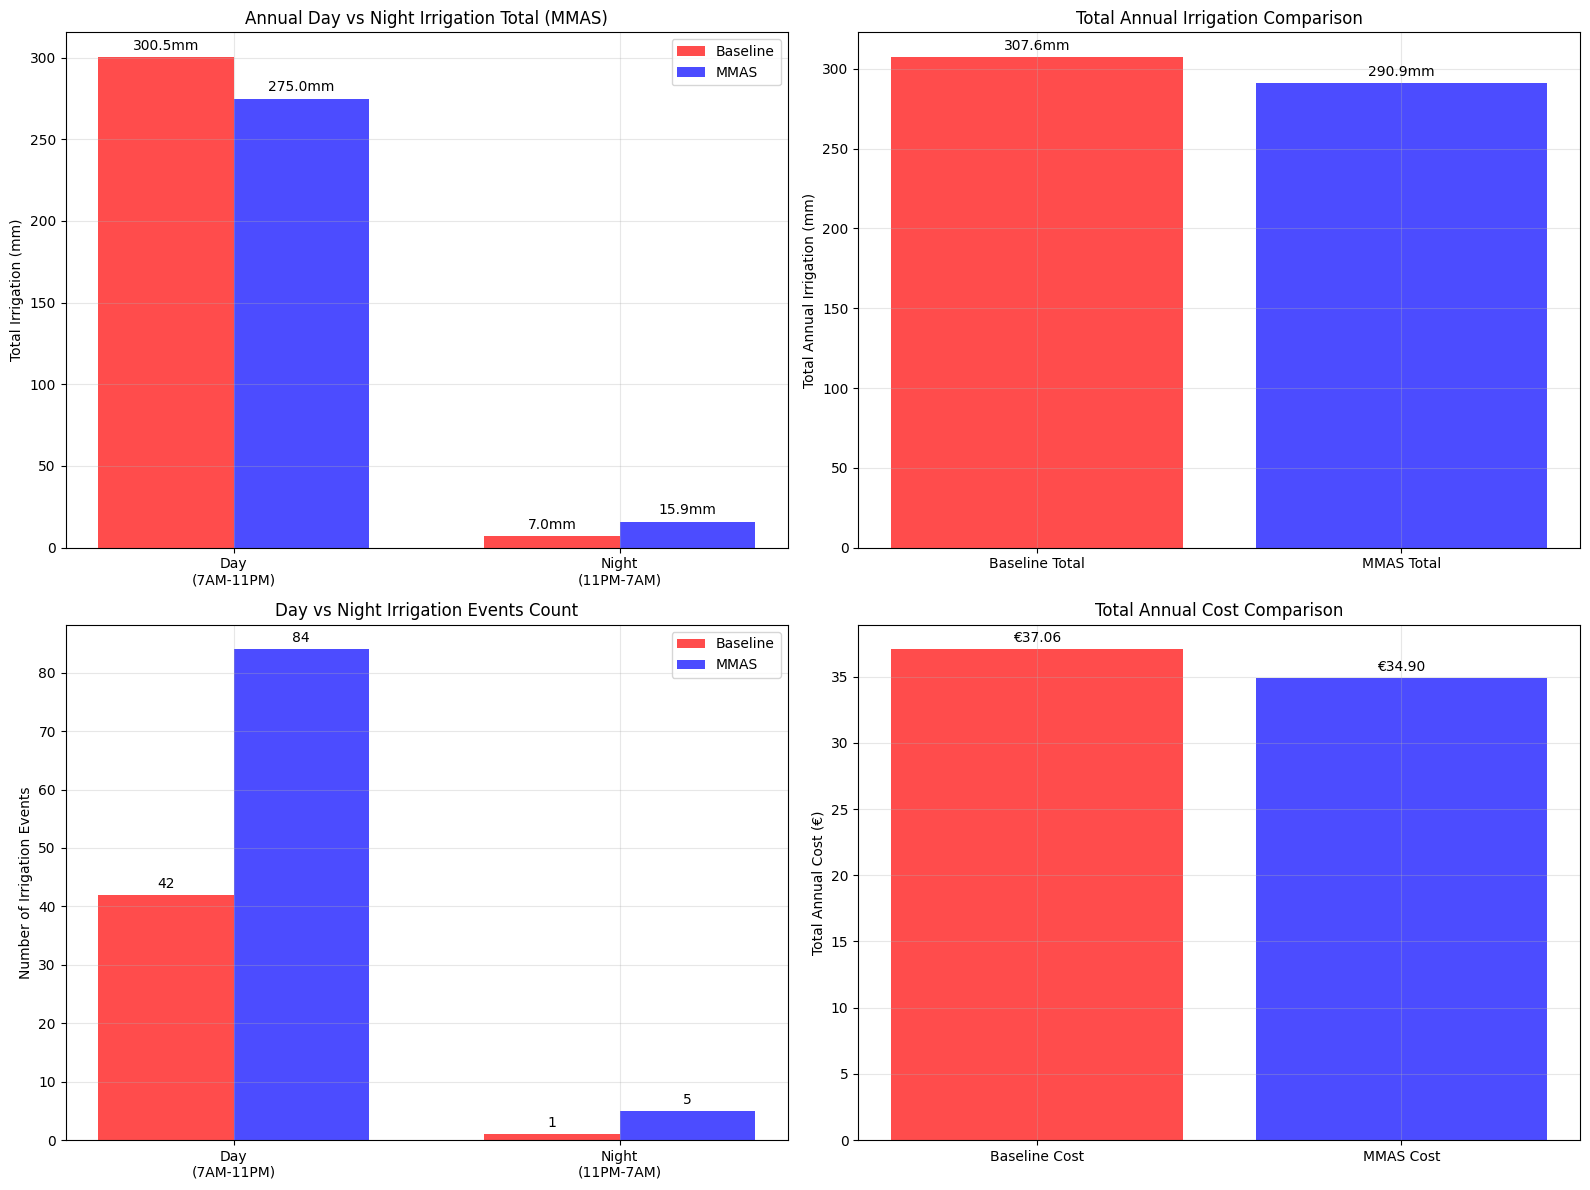


=== MMAS COMPARISON SUMMARY ===
IRRIGATION AMOUNTS:
Baseline total: 307.6mm
MMAS total: 290.9mm
Difference: -16.6mm (-5.4%)

COST COMPARISON:
Baseline cost: €37.06
MMAS cost: €34.90
Savings: €2.16 (5.8%)

TIMING OPTIMIZATION:
MMAS - Day: 275.0mm in 84 events
MMAS - Night: 15.9mm in 5 events
Night irrigation preference:
MMAS: 5.5% of total irrigation
Baseline: 2.3% of total irrigation
MMAS visualizations saved successfully!


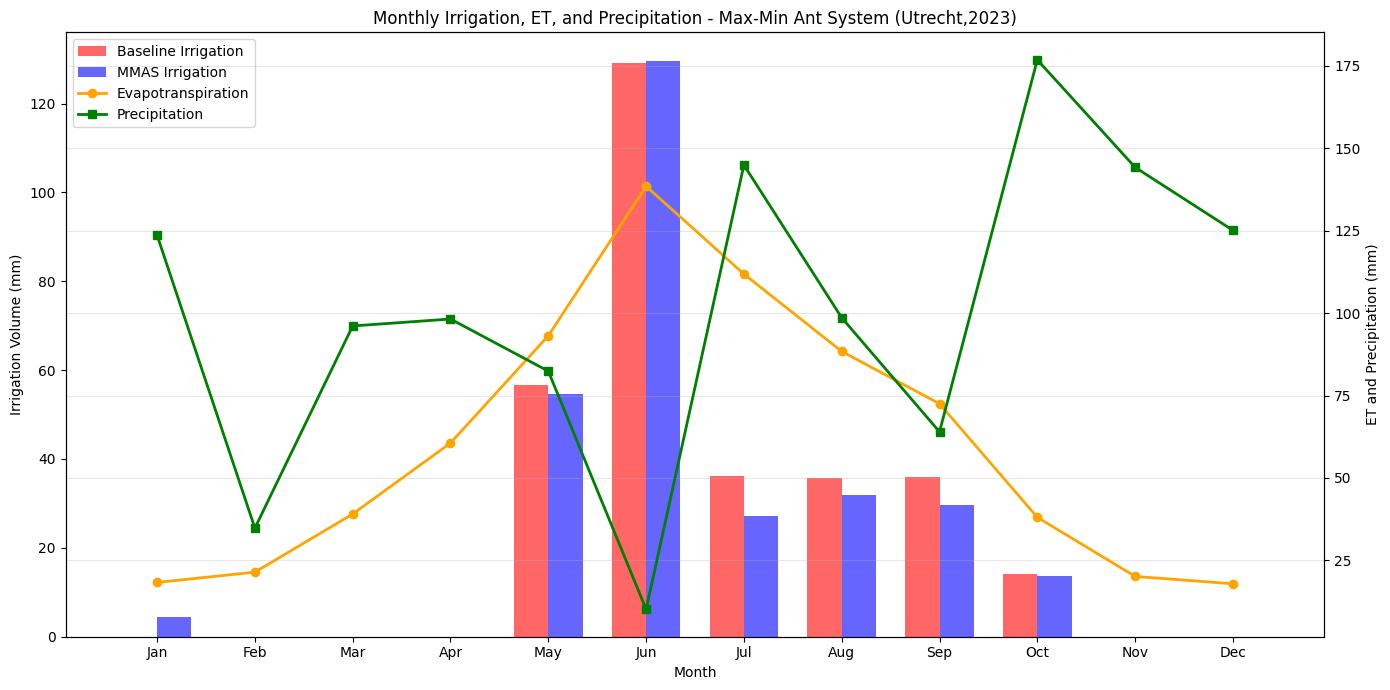


=== MAX-MIN ANT SYSTEM ASSESSMENT ===
Irrigation amount differs from baseline by -5.4%
Cost savings achieved: €2.16
Limited night irrigation: 5.6%


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator, WeekdayLocator
import datetime
import random
import copy
import pandas as pd
from tqdm import tqdm
import os

# Set random seed for reproducibility
np.random.seed(15)
random.seed(15)

class IrrigationSystem:
    def __init__(self, data_file='data.csv', soil_depth=100, 
                 min_moisture=0.18, max_moisture=0.25, saturation_point=0.3,
                 energy_per_unit=0.3, time_steps=8760):
        """
        Initialize the irrigation system for a golf course
        
        Parameters:
        - data_file: CSV file with weather data including ET and precipitation
        - soil_depth: Soil depth in mm
        - min_moisture: Minimum acceptable soil moisture (volumetric fraction)
        - max_moisture: Maximum optimal soil moisture (volumetric fraction)
        - saturation_point: Point at which water drains off (volumetric fraction)
        - energy_per_unit: Energy required per unit of irrigation (kWh/mm)
        - time_steps: Number of time steps (8760 hours for a year)
        """
        # System parameters
        self.num_zones = 1  # Single zone for golf course
        self.min_moisture = min_moisture
        self.max_moisture = max_moisture
        self.saturation_point = saturation_point
        self.soil_depth = soil_depth
        self.energy_per_unit = energy_per_unit
        self.time_steps = time_steps
        self.violation_buffer = 0.05
        
        # Load weather data from CSV
        self.load_weather_data(data_file)
        
        # Energy price model (€/kWh)
        # Create a yearly energy price array
        # Base pattern: 11PM-7AM: €0.34835, 7AM-11PM: €0.40292
        day_prices = np.array([0.34835] * 7 + [0.40292] * 16 + [0.34835] * 1)  
        self.energy_prices = np.tile(day_prices, 365)  # Repeat for 365 days
        
        # Initialize moisture level
        self.reset_moisture_level()
    
    def load_weather_data(self, data_file):
        """Load and process weather data from CSV file"""
        
        # Load data
        if not os.path.exists(data_file):
            raise FileNotFoundError(f"Weather data file '{data_file}' not found.")
        data = pd.read_csv(data_file)
        
        # Extract ET and precipitation data
        self.et_data = data['et0_fao_evapotranspiration (mm)'].values
        self.rain_data = data['rain (mm)'].values
        
        # Verify we have the correct number of hours
        if len(self.et_data) != self.time_steps:
            print(f"Warning: Expected {self.time_steps} hourly records but found {len(self.et_data)}")
            # Adjust time_steps to match data
            self.time_steps = min(self.time_steps, len(self.et_data))
        
    def reset_moisture_level(self):
        """Reset moisture level to random value within acceptable range"""
        # Convert to mm for internal calculations
        min_moisture_mm = self.min_moisture * self.soil_depth
        max_moisture_mm = self.max_moisture * self.soil_depth
        
        # Initialize random moisture level in mm
        moisture_mm = np.random.uniform(min_moisture_mm, max_moisture_mm)
        self.moisture_level = np.array([moisture_mm])
        
        return copy.deepcopy(self.moisture_level)
    
    def mm_to_fraction(self, moisture_mm):
        """Convert moisture in mm to volumetric fraction"""
        return moisture_mm / self.soil_depth
    
    def fraction_to_mm(self, moisture_fraction):
        """Convert volumetric fraction to moisture in mm"""
        return moisture_fraction * self.soil_depth
    
    def simulate_baseline(self, initial_moisture_mm, days=365):
        """
        Simulate baseline irrigation strategy: irrigate immediately when threshold is reached
        Returns energy cost, energy consumption and moisture trajectories
        
        Parameters:
        - initial_moisture_mm: Initial moisture level in mm
        - days: Number of days to simulate (default: 365)
        """
        hours = days * 24
        
        # Initialize tracking variables
        moisture_trajectory = np.zeros(hours)
        fraction_trajectory = np.zeros(hours)
        energy_cost_trajectory = np.zeros(hours)
        energy_consumption_trajectory = np.zeros(hours)
        irrigation_actions = np.zeros(hours)
        
        # Set initial moisture
        current_moisture_mm = copy.deepcopy(initial_moisture_mm)[0]
        
        # Min and max moisture levels in mm
        min_moisture_mm = self.min_moisture * self.soil_depth
        max_moisture_mm = self.max_moisture * self.soil_depth
        saturation_mm = self.saturation_point * self.soil_depth
        
        # Simulate for the specified number of hours
        for hour in range(min(hours, self.time_steps)):
            # Record current moisture (both in mm and as fraction)
            moisture_trajectory[hour] = current_moisture_mm
            fraction_trajectory[hour] = self.mm_to_fraction(current_moisture_mm)
            
            # Apply natural water loss (ET from weather data)
            current_moisture_mm -= self.et_data[hour]
            
            # Add precipitation
            current_moisture_mm += self.rain_data[hour]
            
            # Cap at saturation point (excess water drains off)
            current_moisture_mm = min(current_moisture_mm, saturation_mm)
            
            # Enforce lower bound to prevent extreme dryness
            current_moisture_mm = max(current_moisture_mm, 0)
            
            # Check for irrigation needs (when moisture falls below minimum)
            irrigation_needed = 0
            if current_moisture_mm < min_moisture_mm:
                irrigation_needed = max_moisture_mm - current_moisture_mm
                # Apply irrigation
                current_moisture_mm += irrigation_needed
            
            # Record irrigation actions
            irrigation_actions[hour] = irrigation_needed
            
            # Calculate energy used and cost
            energy_used = irrigation_needed * self.energy_per_unit
            current_price = self.energy_prices[hour]
            energy_cost = energy_used * current_price
            
            # Record energy consumption and cost
            energy_consumption_trajectory[hour] = energy_used
            energy_cost_trajectory[hour] = energy_cost
        
        # Calculate weekly and monthly costs and consumption for visualization
        weekly_costs = [np.sum(energy_cost_trajectory[w*168:(w+1)*168]) for w in range(52)]
        weekly_consumption = [np.sum(energy_consumption_trajectory[w*168:(w+1)*168]) for w in range(52)]
        
        monthly_costs = []
        monthly_consumption = []
        days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
        
        # Adjust for leap year if necessary
        if days == 366:
            days_in_month[1] = 29
        
        hour_index = 0
        for month in range(12):
            month_hours = days_in_month[month] * 24
            monthly_costs.append(np.sum(energy_cost_trajectory[hour_index:hour_index+month_hours]))
            monthly_consumption.append(np.sum(energy_consumption_trajectory[hour_index:hour_index+month_hours]))
            hour_index += month_hours
        
        # Return results
        return {
            'total_cost': np.sum(energy_cost_trajectory),
            'total_consumption': np.sum(energy_consumption_trajectory),
            'weekly_costs': weekly_costs,
            'weekly_consumption': weekly_consumption,
            'monthly_costs': monthly_costs,
            'monthly_consumption': monthly_consumption,
            'moisture_trajectory': moisture_trajectory,
            'fraction_trajectory': fraction_trajectory,
            'energy_cost_trajectory': energy_cost_trajectory,
            'energy_consumption_trajectory': energy_consumption_trajectory,
            'irrigation_actions': irrigation_actions
        }


class MaxMinAntSystem:
    """
    Max-Min Ant System (MMAS) - Advanced ACO variant with pheromone bounds
    Key features:
    - Pheromone bounds (tau_min, tau_max) prevent stagnation
    - Only best ant updates pheromones
    - Pheromone reinitializations when stagnation detected
    - Conservative approach - only irrigates when necessary
    """
    def __init__(self, irrigation_system, num_ants=10, num_iterations=15, 
                 alpha=1.0, beta=2.0, evaporation_rate=0.3, q0=0.8):
        """
        Initialize Max-Min Ant System
        """
        self.irrigation_system = irrigation_system
        self.num_ants = num_ants
        self.num_iterations = num_iterations
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.q0 = q0
        
        # SMALLER action space to prevent over-irrigation
        max_irrigation = 0.25 * self.irrigation_system.soil_depth
        self.possible_actions = np.linspace(0, max_irrigation, 12)
        
        # Initialize pheromone memory
        self.moisture_states = 8
        self.time_states = 24
        
        # MMAS-specific parameters
        self.tau_max = 10.0  # Maximum pheromone level
        self.tau_min = 0.1   # Minimum pheromone level
        self.stagnation_threshold = 5  # Iterations without improvement before reinit
        self.stagnation_counter = 0
        self.best_solution_quality = float('inf')
        
        # Pheromones: [moisture_state, time_state, action]
        self.pheromones = np.full((
            self.moisture_states, 
            self.time_states, 
            len(self.possible_actions)
        ), self.tau_max)  # Initialize to tau_max (MMAS characteristic)
        
        # Track best solutions
        self.iteration_best = None
        self.global_best = None
        self.global_best_quality = float('inf')
        
    def enforce_pheromone_bounds(self):
        """Enforce tau_min and tau_max bounds on all pheromones"""
        self.pheromones = np.clip(self.pheromones, self.tau_min, self.tau_max)
    
    def detect_stagnation_and_reinitialize(self):
        """Detect stagnation and reinitialize pheromones if needed"""
        if self.stagnation_counter >= self.stagnation_threshold:
            print(f"    Stagnation detected, reinitializing pheromones...")
            # Reinitialize pheromones to tau_max
            self.pheromones.fill(self.tau_max)
            self.stagnation_counter = 0
            return True
        return False
        
    def get_moisture_state(self, moisture_mm):
        """Convert moisture level to discrete state"""
        min_moisture = self.irrigation_system.min_moisture * self.irrigation_system.soil_depth
        max_moisture = self.irrigation_system.saturation_point * self.irrigation_system.soil_depth
        
        # Normalize moisture to 0-1 range
        normalized = (moisture_mm - min_moisture) / (max_moisture - min_moisture)
        normalized = max(0, min(1, normalized))
        
        # Convert to discrete state
        state = int(normalized * (self.moisture_states - 1))
        return min(state, self.moisture_states - 1)
    
    def calculate_current_heuristic(self, current_moisture_mm, current_hour):
        """
        CONSERVATIVE heuristic - only irrigate when truly necessary
        """
        heuristic = np.zeros(len(self.possible_actions))  # Start with zeros!
        
        # Basic parameters
        min_moisture_mm = self.irrigation_system.min_moisture * self.irrigation_system.soil_depth
        max_moisture_mm = self.irrigation_system.max_moisture * self.irrigation_system.soil_depth
        saturation_mm = self.irrigation_system.saturation_point * self.irrigation_system.soil_depth
        
        # Current conditions
        current_price = self.irrigation_system.energy_prices[current_hour]
        is_night = current_price < 0.39
        current_rain = self.irrigation_system.rain_data[current_hour] if current_hour < len(self.irrigation_system.rain_data) else 0
        
        # CRITICAL: Only consider irrigation if it's actually needed
        if current_moisture_mm >= min_moisture_mm:
            # No irrigation needed - return all zeros
            return heuristic
        
        # Calculate how much irrigation is actually required
        required_irrigation = max_moisture_mm - current_moisture_mm
        urgency = 1.0
        
        # Calculate heuristic only for reasonable actions
        for a_idx, action in enumerate(self.possible_actions):
            if action == 0:
                # No irrigation action
                if current_moisture_mm >= min_moisture_mm:
                    heuristic[a_idx] = 1.0  # Good to do nothing
                else:
                    heuristic[a_idx] = 0.1  # Bad to do nothing when irrigation needed
                continue
            
            # Check if action makes sense
            final_moisture = current_moisture_mm + action
            
            # Skip actions that cause over-saturation
            if final_moisture > saturation_mm:
                heuristic[a_idx] = 0.01
                continue
            
            # Skip actions during heavy rain
            if current_rain > 2.0:
                heuristic[a_idx] = 0.01
                continue
            
            # Calculate base score based on how well action meets need
            if action >= required_irrigation * 0.8:  # Action covers most of the need
                base_score = 1.0
            elif action >= required_irrigation * 0.5:  # Action covers some of the need
                base_score = 0.7
            else:  # Action is too small
                base_score = 0.3
            
            # Apply urgency
            base_score *= urgency
            
            # Apply timing preferences ONLY if irrigation is needed
            if is_night:
                # Night time bonus - but only if irrigation is actually needed
                base_score *= 1.8
            else:
                # Day time penalty
                base_score *= 0.6
            
            heuristic[a_idx] = max(0.01, base_score)
        
        return heuristic
    
    def make_irrigation_decision(self, current_moisture_mm, current_hour):
        """
        Make conservative irrigation decision using MMAS
        """
        # Get current state
        moisture_state = self.get_moisture_state(current_moisture_mm)
        time_state = current_hour % 24
        
        # Calculate conservative heuristic
        heuristic = self.calculate_current_heuristic(current_moisture_mm, current_hour)
        
        # If all heuristic values are very low, don't irrigate
        if np.max(heuristic) < 0.1:
            return 0.0, {
                'best_quality': 0,
                'avg_quality': 0,
                'moisture_state': moisture_state,
                'time_state': time_state,
                'current_price': self.irrigation_system.energy_prices[current_hour],
                'is_night': self.irrigation_system.energy_prices[current_hour] < 0.39,
                'irrigation_needed': False
            }
        
        # Get pheromone values for current state
        current_pheromones = self.pheromones[moisture_state, time_state, :]
        
        # Run MMAS optimization
        best_action = 0.0
        best_quality = float('inf')
        iteration_best_action = None
        iteration_best_quality = float('inf')
        
        # Track all ant decisions for learning
        ant_actions = []
        ant_qualities = []
        
        for iteration in range(self.num_iterations):
            # Track iteration best
            iteration_ants = []
            iteration_ant_qualities = []
            
            for ant in range(self.num_ants):
                # MMAS Ant decision making with pseudorandom proportional rule
                q = np.random.random()
                
                if q < self.q0:  # Exploitation (best action)
                    action_values = (current_pheromones ** self.alpha) * (heuristic ** self.beta)
                    action_idx = np.argmax(action_values)
                else:  # Exploration (probabilistic)
                    action_probs = (current_pheromones ** self.alpha) * (heuristic ** self.beta)
                    prob_sum = np.sum(action_probs)
                    if prob_sum > 0:
                        action_probs = action_probs / prob_sum
                        action_idx = np.random.choice(len(self.possible_actions), p=action_probs)
                    else:
                        action_idx = 0  # Default to no irrigation
                
                action = self.possible_actions[action_idx]
                
                # Evaluate action
                quality = self.evaluate_single_action(action, current_moisture_mm, current_hour)
                
                iteration_ants.append((action, action_idx))
                iteration_ant_qualities.append(quality)
                
                ant_actions.append((action, action_idx))
                ant_qualities.append(quality)
                
                # Track best
                if quality < best_quality:
                    best_action = action
                    best_quality = quality
            
            # Find iteration best
            if len(iteration_ant_qualities) > 0:
                best_idx = np.argmin(iteration_ant_qualities)
                iteration_best_action = iteration_ants[best_idx]
                iteration_best_quality = iteration_ant_qualities[best_idx]
            
            # MMAS: Only update pheromones every few iterations or at the end
            if iteration == self.num_iterations - 1:
                self.update_pheromones_mmas(moisture_state, time_state, 
                                          iteration_best_action, iteration_best_quality)
        
        # Check for stagnation
        if best_quality >= self.best_solution_quality:
            self.stagnation_counter += 1
        else:
            self.best_solution_quality = best_quality
            self.stagnation_counter = 0
        
        decision_stats = {
            'best_quality': best_quality,
            'avg_quality': np.mean(ant_qualities) if ant_qualities else 0,
            'moisture_state': moisture_state,
            'time_state': time_state,
            'current_price': self.irrigation_system.energy_prices[current_hour],
            'is_night': self.irrigation_system.energy_prices[current_hour] < 0.39,
            'irrigation_needed': True
        }
        
        return best_action, decision_stats
    
    def evaluate_single_action(self, action, current_moisture_mm, current_hour):
        """
        Conservative evaluation with heavy penalties for unnecessary irrigation
        """
        # Project moisture after action and weather
        projected_moisture = current_moisture_mm + action
        
        # Apply current hour's ET and rain
        if current_hour < len(self.irrigation_system.et_data):
            projected_moisture -= self.irrigation_system.et_data[current_hour]
            projected_moisture += self.irrigation_system.rain_data[current_hour]
        
        # Cap at saturation
        saturation_mm = self.irrigation_system.saturation_point * self.irrigation_system.soil_depth
        projected_moisture = min(projected_moisture, saturation_mm)
        projected_moisture = max(0, projected_moisture)
        
        # Calculate energy cost
        energy_cost = action * self.irrigation_system.energy_per_unit * self.irrigation_system.energy_prices[current_hour]
        
        # Conservative penalties
        min_moisture_mm = self.irrigation_system.min_moisture * self.irrigation_system.soil_depth
        max_moisture_mm = self.irrigation_system.max_moisture * self.irrigation_system.soil_depth
        
        penalty = 0
        
        # Under-irrigation penalty
        if projected_moisture < min_moisture_mm:
            penalty += 10.0
        
        # Over-irrigation penalty (very high to prevent waste)
        if projected_moisture > max_moisture_mm + 0.02 * self.irrigation_system.soil_depth:
            penalty += 50.0
        
        # Heavy penalty for unnecessary irrigation
        if action > 0 and current_moisture_mm > min_moisture_mm:
            penalty += 100.0  # Very high penalty for unnecessary irrigation
        
        # Rain waste penalty
        current_rain = self.irrigation_system.rain_data[current_hour] if current_hour < len(self.irrigation_system.rain_data) else 0
        if current_rain > 1.0 and action > 0:
            penalty += current_rain * action * 10.0  # High rain penalty
        
        return energy_cost + penalty
    
    def update_pheromones_mmas(self, moisture_state, time_state, best_action_info, best_quality):
        """
        MMAS pheromone update: only best ant updates, with bounds enforcement
        """
        # Evaporation for all pheromones in this state
        self.pheromones[moisture_state, time_state, :] *= (1 - self.evaporation_rate)
        
        # Only best ant deposits pheromones (MMAS characteristic)
        if best_action_info is not None and best_quality > 0:
            action, action_idx = best_action_info
            
            # Calculate pheromone deposit (inverse of quality)
            pheromone_deposit = 1.0 / (1.0 + best_quality)
            
            # Deposit pheromone only for best action
            self.pheromones[moisture_state, time_state, action_idx] += pheromone_deposit
        
        # Enforce MMAS bounds
        self.enforce_pheromone_bounds()
        
        # Check for stagnation and reinitialize if needed
        self.detect_stagnation_and_reinitialize()


def run_mmas_simulation(irrigation_system, verbose=True):
    """
    Run Max-Min Ant System simulation for the entire year
    """
    
    if verbose:
        print("Starting Max-Min Ant System (MMAS) Simulation:")
        print("- Only irrigates when truly necessary")
        print("- Optimizes timing for cost savings")
        print("- Conservative approach to prevent over-irrigation")
        print("- Uses pheromone bounds and stagnation detection")
    
    # Initialize Max-Min Ant System
    mmas = MaxMinAntSystem(irrigation_system)
    
    # Initialize tracking variables
    full_year_schedule = np.zeros(irrigation_system.time_steps)
    full_year_moisture = np.zeros(irrigation_system.time_steps)
    full_year_fraction = np.zeros(irrigation_system.time_steps)
    full_year_cost = np.zeros(irrigation_system.time_steps)
    full_year_consumption = np.zeros(irrigation_system.time_steps)
    full_year_violations = np.zeros((irrigation_system.time_steps, 2))
    
    # Initialize moisture level
    current_moisture_mm = irrigation_system.reset_moisture_level()[0]
    
    # Track decision statistics
    decision_stats_list = []
    total_violations = 0
    night_irrigation_count = 0
    day_irrigation_count = 0
    total_night_hours = 0
    total_day_hours = 0
    unnecessary_irrigation_prevented = 0
    
    # Create progress bar
    pbar = tqdm(total=irrigation_system.time_steps, desc="MMAS") if verbose else None
    
    # Hour-by-hour reactive decisions
    for hour in range(irrigation_system.time_steps):
        # Record current moisture state
        full_year_moisture[hour] = current_moisture_mm
        full_year_fraction[hour] = irrigation_system.mm_to_fraction(current_moisture_mm)
        
        # Make irrigation decision using MMAS
        irrigation_action, decision_stats = mmas.make_irrigation_decision(current_moisture_mm, hour)
        
        # Track timing statistics
        is_night = decision_stats['is_night']
        if is_night:
            total_night_hours += 1
            if irrigation_action > 0.1:
                night_irrigation_count += 1
        else:
            total_day_hours += 1
            if irrigation_action > 0.1:
                day_irrigation_count += 1
        
        # Track unnecessary irrigation prevention
        if not decision_stats.get('irrigation_needed', True) and irrigation_action < 0.1:
            unnecessary_irrigation_prevented += 1
        
        # Record decision
        full_year_schedule[hour] = irrigation_action
        decision_stats_list.append(decision_stats)
        
        # Apply irrigation
        current_moisture_mm += irrigation_action
        
        # Cap at saturation
        saturation_mm = irrigation_system.saturation_point * irrigation_system.soil_depth
        if current_moisture_mm > saturation_mm:
            current_moisture_mm = saturation_mm
        
        # Calculate energy and cost
        energy_used = irrigation_action * irrigation_system.energy_per_unit
        energy_cost = energy_used * irrigation_system.energy_prices[hour]
        
        full_year_consumption[hour] = energy_used
        full_year_cost[hour] = energy_cost
        
        # Apply ET and rain
        current_moisture_mm -= irrigation_system.et_data[hour]
        current_moisture_mm += irrigation_system.rain_data[hour]
        
        # Cap at saturation again
        current_moisture_mm = min(current_moisture_mm, saturation_mm)
        
        # Check for violations
        min_moisture_mm = irrigation_system.min_moisture * irrigation_system.soil_depth
        max_moisture_mm = irrigation_system.max_moisture * irrigation_system.soil_depth
        
        if current_moisture_mm > (max_moisture_mm + irrigation_system.violation_buffer * irrigation_system.soil_depth):
            full_year_violations[hour, 1] = 1
            total_violations += 1
        if current_moisture_mm < (min_moisture_mm - irrigation_system.violation_buffer * irrigation_system.soil_depth):
            full_year_violations[hour, 0] = 1
            total_violations += 1
        
        # Enforce bounds
        current_moisture_mm = max(current_moisture_mm, 0)
        
        # Update progress bar
        if pbar and hour % 100 == 0:
            pbar.set_postfix({
                'Hour': hour,
                'Moisture': f'{irrigation_system.mm_to_fraction(current_moisture_mm):.2f}',
                'Violations': total_violations,
                'Night_Irrig': f'{night_irrigation_count}',
                'Day_Irrig': f'{day_irrigation_count}'
            })
        
        if pbar:
            pbar.update(1)
    
    if pbar:
        pbar.close()
    
    # Calculate aggregations
    weekly_costs = [np.sum(full_year_cost[w*168:(w+1)*168]) for w in range(52)]
    weekly_consumption = [np.sum(full_year_consumption[w*168:(w+1)*168]) for w in range(52)]
    
    monthly_costs = []
    monthly_consumption = []
    days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    
    hour_index = 0
    for month in range(12):
        month_hours = days_in_month[month] * 24
        monthly_costs.append(np.sum(full_year_cost[hour_index:hour_index+month_hours]))
        monthly_consumption.append(np.sum(full_year_consumption[hour_index:hour_index+month_hours]))
        hour_index += month_hours
    
    # Calculate efficiency metrics
    total_irrigation_events = night_irrigation_count + day_irrigation_count
    night_percentage = (night_irrigation_count / total_irrigation_events * 100) if total_irrigation_events > 0 else 0
    
    # Print summary with conservation stats
    if verbose:
        print(f"\n=== MAX-MIN ANT SYSTEM (MMAS) COMPLETE ===")
        print(f"Total cost: €{np.sum(full_year_cost):.2f}")
        print(f"Total consumption: {np.sum(full_year_consumption):.2f} kWh")
        print(f"Total violations: {total_violations}")
        print(f"Total irrigation events: {total_irrigation_events}")
        print(f"Night irrigation events: {night_irrigation_count} ({night_percentage:.1f}%)")
        print(f"Day irrigation events: {day_irrigation_count}")
        print(f"Unnecessary irrigation prevented: {unnecessary_irrigation_prevented} times")
    
    return {
        'total_cost': np.sum(full_year_cost),
        'pure_cost': np.sum(full_year_cost),
        'total_consumption': np.sum(full_year_consumption),
        'weekly_costs': weekly_costs,
        'weekly_consumption': weekly_consumption,
        'monthly_costs': monthly_costs,
        'monthly_consumption': monthly_consumption,
        'moisture_trajectory': full_year_moisture,
        'fraction_trajectory': full_year_fraction,
        'energy_cost_trajectory': full_year_cost,
        'energy_consumption_trajectory': full_year_consumption,
        'irrigation_actions': full_year_schedule,
        'min_violations': int(np.sum(full_year_violations[:, 0])),
        'max_violations': int(np.sum(full_year_violations[:, 1])),
        'hourly_violations': full_year_violations,
        'decision_stats': decision_stats_list,
        'night_irrigation_count': night_irrigation_count,
        'day_irrigation_count': day_irrigation_count,
        'total_irrigation_events': total_irrigation_events,
        'unnecessary_prevented': unnecessary_irrigation_prevented
    }


def add_day_night_irrigation_plot(irrigation_system, mmas_result, baseline_result, days=365):
    """Day vs night irrigation comparison plot"""
    
    # Calculate day vs night irrigation
    total_day_mmas = 0
    total_night_mmas = 0
    total_day_baseline = 0
    total_night_baseline = 0
    
    # Count irrigation events
    day_events_mmas = 0
    night_events_mmas = 0
    day_events_baseline = 0
    night_events_baseline = 0
    
    for hour in range(min(days * 24, len(mmas_result['irrigation_actions']))):
        hour_of_day = hour % 24
        is_expensive = irrigation_system.energy_prices[hour_of_day] >= 0.39
        
        mmas_irrigation = mmas_result['irrigation_actions'][hour]
        baseline_irrigation = baseline_result['irrigation_actions'][hour]
        
        if is_expensive:  # Day time
            total_day_mmas += mmas_irrigation
            total_day_baseline += baseline_irrigation
            if mmas_irrigation > 0.1:
                day_events_mmas += 1
            if baseline_irrigation > 0.1:
                day_events_baseline += 1
        else:  # Night time
            total_night_mmas += mmas_irrigation
            total_night_baseline += baseline_irrigation
            if mmas_irrigation > 0.1:
                night_events_mmas += 1
            if baseline_irrigation > 0.1:
                night_events_baseline += 1
    
    # Create visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Total irrigation amounts
    categories = ['Day\n(7AM-11PM)', 'Night\n(11PM-7AM)']
    mmas_totals = [total_day_mmas, total_night_mmas]
    baseline_totals = [total_day_baseline, total_night_baseline]
    
    x = np.arange(len(categories))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, baseline_totals, width, label='Baseline', color='red', alpha=0.7)
    bars2 = ax1.bar(x + width/2, mmas_totals, width, label='MMAS', color='blue', alpha=0.7)
    
    ax1.set_ylabel('Total Irrigation (mm)')
    ax1.set_title('Annual Day vs Night Irrigation Total (MMAS)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(categories)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax1.annotate(f'{height:.1f}mm',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')
    
    for bar in bars2:
        height = bar.get_height()
        ax1.annotate(f'{height:.1f}mm',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')
    
    # Plot 2: Total irrigation comparison
    total_mmas = total_day_mmas + total_night_mmas
    total_baseline = total_day_baseline + total_night_baseline
    
    totals = ['Baseline Total', 'MMAS Total']
    amounts = [total_baseline, total_mmas]
    colors = ['red', 'blue']
    
    bars = ax2.bar(totals, amounts, color=colors, alpha=0.7)
    ax2.set_ylabel('Total Annual Irrigation (mm)')
    ax2.set_title('Total Annual Irrigation Comparison')
    ax2.grid(True, alpha=0.3)
    
    for bar in bars:
        height = bar.get_height()
        ax2.annotate(f'{height:.1f}mm',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')
    
    # Plot 3: Irrigation events count
    mmas_events = [day_events_mmas, night_events_mmas]
    baseline_events = [day_events_baseline, night_events_baseline]
    
    bars3 = ax3.bar(x - width/2, baseline_events, width, label='Baseline', color='red', alpha=0.7)
    bars4 = ax3.bar(x + width/2, mmas_events, width, label='MMAS', color='blue', alpha=0.7)
    
    ax3.set_ylabel('Number of Irrigation Events')
    ax3.set_title('Day vs Night Irrigation Events Count')
    ax3.set_xticks(x)
    ax3.set_xticklabels(categories)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Add event count labels
    for bar in bars3:
        height = bar.get_height()
        ax3.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')
    
    for bar in bars4:
        height = bar.get_height()
        ax3.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')
    
    # Plot 4: Cost comparison
    mmas_cost = mmas_result['total_cost']
    baseline_cost = baseline_result['total_cost']
    
    cost_categories = ['Baseline Cost', 'MMAS Cost']
    costs = [baseline_cost, mmas_cost]
    cost_colors = ['red', 'blue']
    
    bars5 = ax4.bar(cost_categories, costs, color=cost_colors, alpha=0.7)
    ax4.set_ylabel('Total Annual Cost (€)')
    ax4.set_title('Total Annual Cost Comparison')
    ax4.grid(True, alpha=0.3)
    
    for bar in bars5:
        height = bar.get_height()
        ax4.annotate(f'€{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('mmas_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print comprehensive statistics
    print(f"\n=== MMAS COMPARISON SUMMARY ===")
    print(f"IRRIGATION AMOUNTS:")
    print(f"Baseline total: {total_baseline:.1f}mm")
    print(f"MMAS total: {total_mmas:.1f}mm")
    print(f"Difference: {total_mmas - total_baseline:.1f}mm ({((total_mmas - total_baseline)/total_baseline*100):.1f}%)")
    print(f"\nCOST COMPARISON:")
    print(f"Baseline cost: €{baseline_cost:.2f}")
    print(f"MMAS cost: €{mmas_cost:.2f}")
    print(f"Savings: €{baseline_cost - mmas_cost:.2f} ({((baseline_cost - mmas_cost)/baseline_cost*100):.1f}%)")
    print(f"\nTIMING OPTIMIZATION:")
    print(f"MMAS - Day: {total_day_mmas:.1f}mm in {day_events_mmas} events")
    print(f"MMAS - Night: {total_night_mmas:.1f}mm in {night_events_mmas} events")
    
    night_preference_mmas = (total_night_mmas / total_mmas * 100) if total_mmas > 0 else 0
    night_preference_baseline = (total_night_baseline / total_baseline * 100) if total_baseline > 0 else 0
    
    print(f"Night irrigation preference:")
    print(f"MMAS: {night_preference_mmas:.1f}% of total irrigation")
    print(f"Baseline: {night_preference_baseline:.1f}% of total irrigation")


def visualize_results(irrigation_system, mmas_result, baseline_result, days=365):
    """Create visualizations comparing MMAS with baseline"""
    
    # Figure 1: Monthly Energy Costs
    plt.figure(figsize=(12, 6))
    mmas_monthly_costs = mmas_result['monthly_costs']
    baseline_monthly_costs = baseline_result['monthly_costs']
    
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    x = np.arange(len(months))
    width = 0.35
    
    plt.bar(x - width/2, baseline_monthly_costs, width, label='Baseline', color='r', alpha=0.7)
    plt.bar(x + width/2, mmas_monthly_costs, width, label='MMAS', color='b', alpha=0.7)
    
    plt.xlabel('Month')
    plt.ylabel('Energy Cost (€)')
    plt.title('Monthly Energy Cost Comparison - Max-Min Ant System (Utrecht,2023)')
    plt.xticks(x, months)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('mmas_monthly_energy_costs.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Figure 2: Comprehensive comparison
    print("Creating comprehensive comparison for MMAS...")
    add_day_night_irrigation_plot(irrigation_system, mmas_result, baseline_result, days)
    
    print("MMAS visualizations saved successfully!")

    # Calculate total irrigation volume by month
    monthly_mmas_irrigation = []
    monthly_baseline_irrigation = []
    monthly_et = []
    monthly_rain = []
    
    days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]  # Standard year
    hour_index = 0
    
    for month in range(12):
        month_hours = days_in_month[month] * 24
        
        monthly_mmas_irrigation.append(np.sum(mmas_result['irrigation_actions'][hour_index:hour_index+month_hours]))
        monthly_baseline_irrigation.append(np.sum(baseline_result['irrigation_actions'][hour_index:hour_index+month_hours]))
        monthly_et.append(np.sum(irrigation_system.et_data[hour_index:hour_index+month_hours]))
        monthly_rain.append(np.sum(irrigation_system.rain_data[hour_index:hour_index+month_hours]))
        
        hour_index += month_hours
    
    # Create positions for bars
    x = np.arange(len(months))
    width = 0.35
    
    # Create bar chart
    fig, ax1 = plt.subplots(figsize=(14, 7))
    
    # Irrigation data on left y-axis
    ax1.bar(x - width/2, monthly_baseline_irrigation, width, label='Baseline Irrigation', color='r', alpha=0.6)
    ax1.bar(x + width/2, monthly_mmas_irrigation, width, label='MMAS Irrigation', color='b', alpha=0.6)
    ax1.set_ylabel('Irrigation Volume (mm)')
    ax1.set_xlabel('Month')
    ax1.set_title('Monthly Irrigation, ET, and Precipitation - Max-Min Ant System (Utrecht,2023)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(months)
    
    # Create second y-axis for ET and rain
    ax2 = ax1.twinx()
    ax2.plot(x, monthly_et, 'orange', marker='o', linestyle='-', linewidth=2, label='Evapotranspiration')
    ax2.plot(x, monthly_rain, 'green', marker='s', linestyle='-', linewidth=2, label='Precipitation')
    ax2.set_ylabel('ET and Precipitation (mm)')
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('mmas_annual_water_distribution.png')
    plt.show()


def mmas_simulation(days=365):
    """
    Run Max-Min Ant System simulation with comparison to baseline
    """
    # Create irrigation system
    irrigation_system = IrrigationSystem()
    
    # Store initial moisture level for fair comparison
    initial_moisture_mm = irrigation_system.reset_moisture_level()
    
    # Run MMAS optimization
    print("Running Max-Min Ant System (MMAS) optimization...")
    mmas_result = run_mmas_simulation(irrigation_system, verbose=True)
    
    # Run baseline for comparison
    print("\nRunning baseline simulation...")
    baseline_result = irrigation_system.simulate_baseline(initial_moisture_mm, days=days)
    
    # Calculate performance metrics
    total_mmas_cost = mmas_result['pure_cost']
    total_baseline_cost = baseline_result['total_cost']
    savings = total_baseline_cost - total_mmas_cost
    savings_percentage = (savings / total_baseline_cost) * 100
    
    total_mmas_consumption = mmas_result['total_consumption']
    total_baseline_consumption = baseline_result['total_consumption']
    consumption_diff = total_mmas_consumption - total_baseline_consumption
    consumption_diff_percentage = (consumption_diff / total_baseline_consumption) * 100
    
    total_mmas_irrigation = np.sum(mmas_result['irrigation_actions'])
    total_baseline_irrigation = np.sum(baseline_result['irrigation_actions'])
    irrigation_diff = total_mmas_irrigation - total_baseline_irrigation
    irrigation_diff_percentage = (irrigation_diff / total_baseline_irrigation) * 100
    
    print(f"\n=== MAX-MIN ANT SYSTEM (MMAS) RESULTS SUMMARY ===")
    print(f"IRRIGATION AMOUNTS:")
    print(f"Baseline total irrigation: {total_baseline_irrigation:.1f}mm")
    print(f"MMAS total irrigation: {total_mmas_irrigation:.1f}mm")
    print(f"Irrigation difference: {irrigation_diff:.1f}mm ({irrigation_diff_percentage:.1f}%)")
    
    print(f"\nENERGY CONSUMPTION:")
    print(f"Baseline consumption: {total_baseline_consumption:.2f} kWh")
    print(f"MMAS consumption: {total_mmas_consumption:.2f} kWh")
    print(f"Consumption difference: {consumption_diff:.2f} kWh ({consumption_diff_percentage:.1f}%)")
    
    print(f"\nCOST ANALYSIS:")
    print(f"Baseline total cost: €{total_baseline_cost:.2f}")
    print(f"MMAS total cost: €{total_mmas_cost:.2f}")
    if savings > 0:
        print(f"Cost savings: €{savings:.2f} ({savings_percentage:.2f}%)")
    else:
        print(f"Cost increase: €{-savings:.2f} ({-savings_percentage:.2f}%)")
    
    # Timing analysis
    if 'total_irrigation_events' in mmas_result:
        total_events = mmas_result['total_irrigation_events']
        night_events = mmas_result['night_irrigation_count']
        day_events = mmas_result['day_irrigation_count']
        night_percentage = (night_events / total_events * 100) if total_events > 0 else 0
        
        print(f"\nTIMING OPTIMIZATION:")
        print(f"Total irrigation events: {total_events}")
        print(f"Night irrigation events: {night_events} ({night_percentage:.1f}%)")
        print(f"Day irrigation events: {day_events} ({100-night_percentage:.1f}%)")
        print(f"Unnecessary irrigation prevented: {mmas_result.get('unnecessary_prevented', 0)} times")
    
    # Constraint violations
    print(f"\nCONSTRAINT VIOLATIONS:")
    print(f"MMAS violations: {mmas_result['min_violations'] + mmas_result['max_violations']}")

    
    # Visualize results
    visualize_results(irrigation_system, mmas_result, baseline_result, days)
    
    # Final assessment
    print(f"\n=== MAX-MIN ANT SYSTEM ASSESSMENT ===")
    if abs(irrigation_diff_percentage) < 5:
        print(f"Irrigation amount closely matches baseline ({irrigation_diff_percentage:.1f}% difference)")
    else:
        print(f"Irrigation amount differs from baseline by {irrigation_diff_percentage:.1f}%")
    
    if savings > 0:
        print(f"Cost savings achieved: €{savings:.2f}")
    else:
        print(f"Cost increased by: €{-savings:.2f}")
    
    if night_percentage > 30:
        print(f"Good night irrigation preference: {night_percentage:.1f}%")
    else:
        print(f"Limited night irrigation: {night_percentage:.1f}%")
    
    return mmas_result, baseline_result


if __name__ == "__main__":
    # Run Max-Min Ant System simulation
    print("=== MAX-MIN ANT SYSTEM (MMAS) IRRIGATION OPTIMIZATION ===")
    print("This system is designed to:")
    print("- Match baseline irrigation amounts (no over-irrigation)")
    print("- Only irrigate when truly necessary")
    print("- Optimize timing to prefer cheaper night hours")
    print("- Use conservative heuristics")
    print("- Prevent unnecessary irrigation through conservative heuristics")
    print("- Use pheromone bounds (tau_min, tau_max) to prevent stagnation")
    print("- Only allow best ant to update pheromones")
    print("- Reinitialize pheromones when stagnation is detected")
    print()
    
    mmas_result, baseline_result = mmas_simulation(days=365)